In [1]:
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.layers import *
from keras.optimizers import *
from keras.models import Model
from keras.callbacks import *
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from joblib import Parallel, delayed

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### settings

In [2]:
save_dir = "./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/"

In [3]:
N_SPLITS = 5
MAX_THREADS = 8
N_TRAIN = 10
max_num = 127
min_num = -128

### process

In [4]:
from scipy.signal import butter, sosfilt
import pywt

n_samples = 800000
sample_duration = 0.02
sample_rate = n_samples * (1 / sample_duration)

def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    # scipy version 1.1.0
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = sosfilt(sos, x)
    return filtered_sig

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )
    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log(len(x)))
    coeff[1:] = (pywt.threshold( i, value=uthresh, mode='hard') for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff, wavelet, mode='per')

In [5]:
df_train = pd.read_csv('../data/input/metadata_train.csv')
df_train = df_train.set_index(['id_measurement', 'phase'])

In [6]:
def get_features(dataset='train', split_parts=10):
    if dataset == 'train':
        cache_file = 'X.npy'
        meta_file = '../data/input/metadata_train.csv'
    elif dataset == 'test':
        cache_file = 'X_test.npy'
        meta_file = '../data/input/metadata_test.csv'

    meta_df = pd.read_csv(meta_file)

    data_measurements = meta_df.pivot(
        index='id_measurement', columns='phase', values='signal_id'
    )
    data_measurements = data_measurements.values
    data_measurements = np.array_split(data_measurements, split_parts, axis=0)
    X = Parallel(n_jobs=min(split_parts, MAX_THREADS), verbose=1)(delayed(prep_data)(p, dataset) for p in data_measurements)
    X = np.concatenate(X, axis=0)

    if dataset == 'train':
        # y = meta_df.loc[meta_df['phase']==0, 'target'].values
        # y = meta_df.groupby("id_measurement")["target"].max().sort_index().values
        y = meta_df.groupby("id_measurement")["target"].sum().values
        y[y < 2] = 0
        y[y >= 2] = 1

        np.save(save_dir + "X.npy", X)
        np.save(save_dir + "y.npy", y)
    elif dataset == 'test':
        y = None
        np.save(save_dir + "X_test.npy", X)

    return X, y

In [7]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [8]:
def get_cancellation_point(signals, max_thres=127, min_thres=-128, maxTicksRemoval=500):
    # 1つのphaseにおける時系列データのキャンセル点を特定する
    signals_cancelled = signals.copy()
    argmax_point = np.where(signals >= max_thres)[0]
    argmin_point = np.where(signals <= min_thres)[0]
    cancell_point = []

    for point in argmin_point:
        cancell_area = np.arange(point, min(point+maxTicksRemoval, len(signals)-1))
        cancell_point.append(cancell_area)
    for point in argmax_point:
        cancell_area = np.arange(point, min(point+maxTicksRemoval, len(signals)-1))
        cancell_point.append(cancell_area)
    
    if len(cancell_point) > 0:
        cancell_point = np.unique(np.concatenate(cancell_point))

    return cancell_point

In [14]:
def get_cancellation_points_3(praq_data, sids):
    # 3つのphaseのキャンセル点をマージ
    cancell_point_3 = []
    for s in sids:
        signals = praq_data[str(s)].values
        cancell_point = get_cancellation_point(
            signals, max_thres=max_num, min_thres=min_num)
        cancell_point_3.append(cancell_point)
    
    cancell_point_3 = np.unique(np.concatenate(cancell_point_3).astype(int))
    return cancell_point_3

In [15]:
def processing_cancellation(signals, cancell_point_3):
    # 指定されたキャンセル点を前後の平均で埋める
    mean_area = 100
    signals_cancelled = signals.copy()

    for point in cancell_point_3:
        if point+mean_area >= len(signals):
            signals_cancelled[point] = signals[point-mean_area : len(signals)].mean()
        elif point-mean_area < 0:
            signals_cancelled[point] = signals[0 : point+mean_area].mean()
        else:
            signals_cancelled[point] = signals[point-mean_area : point+mean_area].mean()

    return signals_cancelled

In [31]:
def prep_data(signal_ids, dataset="train"):
    signal_ids_all = np.concatenate(signal_ids)
    if dataset == "train":
        praq_data = pq.read_pandas('../data/input/train.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    elif dataset == "test":
        praq_data = pq.read_pandas('../data/input/test.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    else:
        raise ValueError("Unknown dataset")

    X = []
    for sids in signal_ids:
        cancell_point_3 = get_cancellation_points_3(praq_data, sids)
        signals_3 = praq_data[[str(s) for s in sids]].values.T
        
        X_signal = []
        for i in range(3):
            signals = signals_3[i, :]
            if len(cancell_point_3) > 0:
                signals = processing_cancellation(signals, cancell_point_3)

            feature = transform_ts(signals)
            X_signal.append(feature)
            
        X_signal = np.concatenate(X_signal, axis=1)
        X.append(X_signal)

    X = np.asarray(X)
    return X

In [32]:
from scipy.signal import butter, sosfilt, find_peaks, peak_prominences
import pywt
distance = 50
prominence = 1 / max_num
    
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    #ts = high_pass_filter(ts, low_cutoff=10000)
    ts = denoise_signal(ts, wavelet='db4', level=1)
    ts = min_max_transf(ts, min_data=min_num, max_data=max_num)
    sample_size = 800000
    bucket_size = int(sample_size / n_dim)
    new_ts = []
    
    for i in range(0, sample_size, bucket_size):
        ts_range = ts[i:i + bucket_size]
        mean = ts_range.mean()
        std = ts_range.std()
        std_top = mean + std
        std_bot = mean - std
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])
        max_range = percentil_calc[-1] - percentil_calc[0]
        relative_percentile = percentil_calc - mean # maybe it could heap to understand the asymmetry

        """
        pos_peaks, _ = find_peaks(ts_range, distance=distance, prominence=prominence)
        neg_peaks, _ = find_peaks(ts_range*-1, distance=distance, prominence=prominence)
        widths = np.diff(pos_peaks)
        prominences = peak_prominences(ts_range, pos_peaks)[0]
        peak_result = {
            'pos_peak_count': pos_peaks.size,
            'neg_peak_count': neg_peaks.size,
            'peak_count_buchet': pos_peaks.size + neg_peaks.size,
            'width_mean_buchet': widths.mean() / bucket_size if widths.size else 1.,
            'width_max_buchet': widths.max() / bucket_size if widths.size else 1.,
            'width_min_buchet': widths.min() / bucket_size if widths.size else 1.,
            'prominence_mean_buchet': prominences.mean() / 2 if prominences.size else 0.,
            'prominence_max_buchet': prominences.max() / 2 if prominences.size else 0.,
            'prominence_min_buchet': prominences.min() / 2 if prominences.size else 0.,
        }
        peak_result = np.array(list(peak_result.values())).astype(float)
        new_ts.append(peak_result)
        print(peak_result)
        """
        new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]), percentil_calc, relative_percentile]))
    return np.asarray(new_ts)

In [33]:
X, y = get_features("train", split_parts=8)
print(X.shape, y.shape)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  3.3min remaining:  9.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  3.4min finished


(2904, 160, 57) (2904,)


In [34]:
X = np.load(save_dir + "X.npy")
y = np.load(save_dir + "y.npy")
print(X.shape, y.shape)

(2904, 160, 57) (2904,)


In [35]:
%%time
meta_test = pd.read_csv('../data/input/metadata_test.csv')
meta_test = meta_test.set_index(['signal_id'])
X_test_input, _ = get_features("test", split_parts=8)
X_test_input.shape

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  7.7min remaining: 23.1min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  8.0min finished


CPU times: user 1.53 s, sys: 2.53 s, total: 4.06 s
Wall time: 7min 59s


In [36]:
X_test_input = np.load(save_dir + "X_test.npy")
print(X_test_input.shape)

(6779, 160, 57)


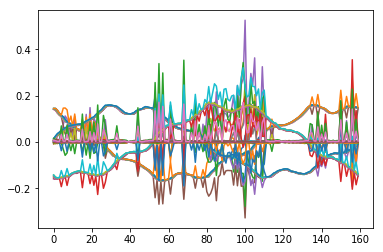

In [37]:
plt.plot(X[0, :, :])
plt.show()

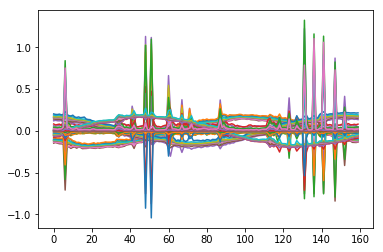

In [38]:
plt.plot(X[6878//3, :, :])
plt.show()

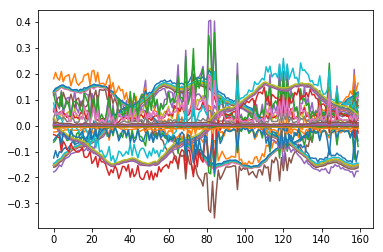

In [39]:
plt.plot(X_test_input[0, :, :])
plt.show()

### set model

In [40]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [41]:
def model_lstm(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    
    return model

In [42]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

### train adversal validation

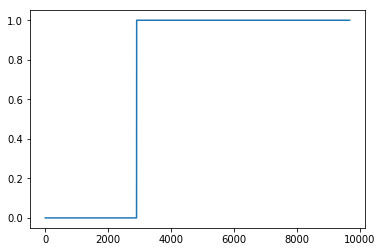

((9683, 160, 57), (9683,), 6779.0)

In [43]:
X_total = np.concatenate((X, X_test_input))
y_total = np.ones(len(X_total))
y_total[:len(X)] = 0

plt.plot(y_total)
plt.show()
X_total.shape, y_total.shape, y_total.sum()

In [44]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)), str(round(roc_val,4))), end=100*' '+'\n')
        logs['val_auc'] = roc_val
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [45]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_total, y_total))
preds_val = []
y_val = []

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X_total[train_idx], y_total[train_idx], X_total[val_idx], y_total[val_idx]
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    ckpt = ModelCheckpoint(
        save_dir + 'weights_{}.h5'.format(idx), save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_auc', mode='max'
    )
    roc_auc = roc_callback(training_data=(train_X, train_y), validation_data=(val_X, val_y))
    early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode="max")

    model.fit(
        train_X, train_y, batch_size=128, epochs=100,
        validation_data=[val_X, val_y], callbacks=[roc_auc, ckpt, early_stopping]
    )
    
    model.load_weights(save_dir + 'weights_{}.h5'.format(idx))
    preds_val.append(model.predict(val_X, batch_size=512))
    y_val.append(val_y)

preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

Beginning fold 1
Train on 7746 samples, validate on 1937 samples
Epoch 1/100
7746/7746 [==============================] - 43s 6ms/step - loss: 0.6194 - val_loss: 0.6035
roc-auc: 0.5573 - roc-auc_val: 0.592                                                                                                    

Epoch 00001: val_auc improved from -inf to 0.59203, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_0.h5
Epoch 2/100
7746/7746 [==============================] - 3s 432us/step - loss: 0.6065 - val_loss: 0.5967
roc-auc: 0.577 - roc-auc_val: 0.5884                                                                                                    

Epoch 00002: val_auc did not improve from 0.59203
Epoch 3/100
7746/7746 [==============================] - 3s 424us/step - loss: 0.5992 - val_loss: 0.5867
roc-auc: 0.6116 - roc-auc_val: 0.6476                                                                                                    

Epoch 00003: val_auc 

7746/7746 [==============================] - 3s 437us/step - loss: 0.2489 - val_loss: 0.2998
roc-auc: 0.9416 - roc-auc_val: 0.933                                                                                                    

Epoch 00025: val_auc did not improve from 0.94824
Epoch 26/100
7746/7746 [==============================] - 3s 427us/step - loss: 0.2418 - val_loss: 0.2465
roc-auc: 0.9622 - roc-auc_val: 0.9518                                                                                                    

Epoch 00026: val_auc improved from 0.94824 to 0.95176, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_0.h5
Epoch 27/100
7746/7746 [==============================] - 3s 435us/step - loss: 0.2269 - val_loss: 0.2316
roc-auc: 0.9651 - roc-auc_val: 0.9569                                                                                                    

Epoch 00027: val_auc improved from 0.95176 to 0.95686, saving model to ./save/kernel_5-fold

7746/7746 [==============================] - 3s 427us/step - loss: 0.1675 - val_loss: 0.2953
roc-auc: 0.9616 - roc-auc_val: 0.9484                                                                                                    

Epoch 00050: val_auc did not improve from 0.97279
Epoch 51/100
7746/7746 [==============================] - 3s 426us/step - loss: 0.2041 - val_loss: 0.2506
roc-auc: 0.9685 - roc-auc_val: 0.9556                                                                                                    

Epoch 00051: val_auc did not improve from 0.97279
Epoch 52/100
7746/7746 [==============================] - 3s 428us/step - loss: 0.1764 - val_loss: 0.2180
roc-auc: 0.9791 - roc-auc_val: 0.9637                                                                                                    

Epoch 00052: val_auc did not improve from 0.97279
Epoch 53/100
7746/7746 [==============================] - 3s 428us/step - loss: 0.1550 - val_loss: 0.1970
roc-auc: 0.9853 - roc-

7746/7746 [==============================] - 3s 427us/step - loss: 0.2855 - val_loss: 0.2567
roc-auc: 0.9568 - roc-auc_val: 0.9493                                                                                                    

Epoch 00021: val_auc improved from 0.94773 to 0.94930, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1.h5
Epoch 22/100
7746/7746 [==============================] - 3s 426us/step - loss: 0.2618 - val_loss: 0.2913
roc-auc: 0.9431 - roc-auc_val: 0.9341                                                                                                    

Epoch 00022: val_auc did not improve from 0.94930
Epoch 23/100
7746/7746 [==============================] - 3s 429us/step - loss: 0.2532 - val_loss: 0.2362
roc-auc: 0.964 - roc-auc_val: 0.9561                                                                                                    

Epoch 00023: val_auc improved from 0.94930 to 0.95606, saving model to ./save/kernel_5-fold

7746/7746 [==============================] - 3s 410us/step - loss: 0.4884 - val_loss: 0.4576
roc-auc: 0.8216 - roc-auc_val: 0.8192                                                                                                    

Epoch 00010: val_auc did not improve from 0.87189
Epoch 11/100
7746/7746 [==============================] - 3s 428us/step - loss: 0.4508 - val_loss: 0.4130
roc-auc: 0.8692 - roc-auc_val: 0.8649                                                                                                    

Epoch 00011: val_auc did not improve from 0.87189
Epoch 12/100
7746/7746 [==============================] - 3s 429us/step - loss: 0.4274 - val_loss: 0.4177
roc-auc: 0.8901 - roc-auc_val: 0.8929                                                                                                    

Epoch 00012: val_auc improved from 0.87189 to 0.89290, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_2.h5
Epoch 13/100
7746/7746 [================

7748/7748 [==============================] - 3s 395us/step - loss: 0.5302 - val_loss: 0.4911
roc-auc: 0.7922 - roc-auc_val: 0.7841                                                                                                    

Epoch 00006: val_auc improved from 0.70416 to 0.78412, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_4.h5
Epoch 7/100
7748/7748 [==============================] - 3s 401us/step - loss: 0.5200 - val_loss: 0.5520
roc-auc: 0.7198 - roc-auc_val: 0.7218                                                                                                    

Epoch 00007: val_auc did not improve from 0.78412
Epoch 8/100
7748/7748 [==============================] - 3s 427us/step - loss: 0.5013 - val_loss: 0.4893
roc-auc: 0.8035 - roc-auc_val: 0.7921                                                                                                    

Epoch 00008: val_auc improved from 0.78412 to 0.79205, saving model to ./save/kernel_5-fold_

7748/7748 [==============================] - 3s 408us/step - loss: 0.2255 - val_loss: 0.2807
roc-auc: 0.9615 - roc-auc_val: 0.9483                                                                                                    

Epoch 00030: val_auc did not improve from 0.95893
Epoch 31/100
7748/7748 [==============================] - 3s 425us/step - loss: 0.2079 - val_loss: 0.2424
roc-auc: 0.9725 - roc-auc_val: 0.9552                                                                                                    

Epoch 00031: val_auc did not improve from 0.95893
Epoch 32/100
7748/7748 [==============================] - 3s 423us/step - loss: 0.1976 - val_loss: 0.2234
roc-auc: 0.9791 - roc-auc_val: 0.9605                                                                                                    

Epoch 00032: val_auc improved from 0.95893 to 0.96050, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_4.h5
Epoch 33/100
7748/7748 [================

((9683,), (9683,))

In [46]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, preds_val)

0.9457183899638204

In [47]:
target = np.ones(len(X_total))
target = target * -1
target[:len(y)] = y
target.shape, target[target != -1].sum(), y.sum()

((9683,), 175.0, 175)

In [48]:
val_idx_list = []
for idx, (train_idx, val_idx) in enumerate(splits):
    val_idx_list.append(val_idx)
val_idx_list = np.concatenate(val_idx_list)

In [49]:
result = []
for idx, preds, test_flg in zip(val_idx_list, preds_val, y_val):
    result.append((idx, preds, test_flg))

result = pd.DataFrame(result, columns=["idx", "preds", "test_flg"])
result = result.sort_values("idx").reset_index(drop=True)
result["target"] = target
result.head()

,idx,preds,test_flg,target
0,0,0.009934,0.0,0.0
1,1,0.652635,0.0,1.0
2,2,0.009701,0.0,0.0
3,3,0.009708,0.0,0.0
4,4,0.005318,0.0,0.0


175.0


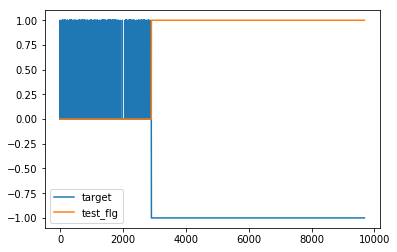

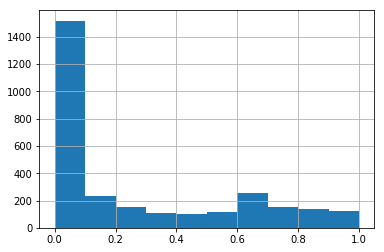

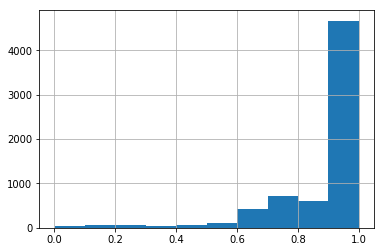

In [50]:
# check
print(result.query("test_flg == 0").target.sum())
result[["target", "test_flg"]].plot()
plt.show()
result.query("test_flg == 0").preds.hist()
plt.show()
result.query("test_flg == 1").preds.hist()
plt.show()

In [51]:
result.to_csv(save_dir + "adversarial_validation_result.csv", index=False, header=True)

### get adversal validation result

In [52]:
ad_result = pd.read_csv(save_dir + "adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0")
print(ad_train.test_flg.sum(), ad_train.target.sum(), y.sum())
ad_train.head()

0.0 175.0 175


,idx,preds,test_flg,target
0,0,0.009934,0.0,0.0
1,1,0.652635,0.0,1.0
2,2,0.009701,0.0,0.0
3,3,0.009708,0.0,0.0
4,4,0.005318,0.0,0.0


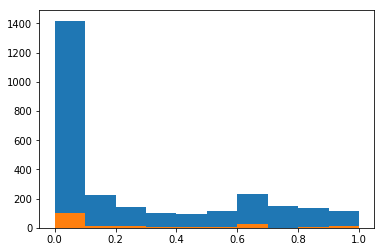

In [53]:
plt.hist(ad_train.query("target == 0")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.hist(ad_train.query("target == 1")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.show()

In [54]:
# cut adversarial probabilities (for train) in 5 buckets
adver_idx_08_to_1 = ad_train.query("preds >= 0.80").idx.tolist()
adver_idx_06_to_08 = ad_train.query("0.80 > preds >= 0.60").idx.tolist()
adver_idx_04_to_06 = ad_train.query("0.60 > preds >= 0.40").idx.tolist()
adver_idx_02_to_04 = ad_train.query("0.40 > preds >= 0.20").idx.tolist()
adver_idx_00_to_02 = ad_train.query("0.20 > preds >= 0.00").idx.tolist()

print(len(adver_idx_08_to_1), len(adver_idx_06_to_08), len(adver_idx_04_to_06), len(adver_idx_02_to_04), len(adver_idx_00_to_02))
print(len(adver_idx_08_to_1)+len(adver_idx_06_to_08)+len(adver_idx_04_to_06)+len(adver_idx_02_to_04)+len(adver_idx_00_to_02))
print(len(y))

print(y[adver_idx_08_to_1].sum(), y[adver_idx_06_to_08].sum(), y[adver_idx_04_to_06].sum(), y[adver_idx_02_to_04].sum(), y[adver_idx_00_to_02].sum())
print(y[adver_idx_08_to_1].sum()+y[adver_idx_06_to_08].sum()+y[adver_idx_04_to_06].sum()+y[adver_idx_02_to_04].sum()+y[adver_idx_00_to_02].sum())
print(y.sum())

266 410 217 258 1753
2904
2904
12 31 7 14 111
175
175


In [55]:
adver_idx_08_to_1_pos = ad_train.query("preds >= 0.80 & target == 1").idx.tolist()
adver_idx_06_to_08_pos = ad_train.query("0.80 > preds >= 0.60 & target == 1").idx.tolist()
adver_idx_04_to_06_pos = ad_train.query("0.60 > preds >= 0.40 & target == 1").idx.tolist()
adver_idx_02_to_04_pos = ad_train.query("0.40 > preds >= 0.20 & target == 1").idx.tolist()
adver_idx_00_to_02_pos = ad_train.query("0.20 > preds >= 0.00 & target == 1").idx.tolist()

print(len(adver_idx_08_to_1_pos), len(adver_idx_06_to_08_pos), len(adver_idx_04_to_06_pos), len(adver_idx_02_to_04_pos), len(adver_idx_00_to_02_pos))
print(len(adver_idx_08_to_1_pos)+len(adver_idx_06_to_08_pos)+len(adver_idx_04_to_06_pos)+len(adver_idx_02_to_04_pos)+len(adver_idx_00_to_02_pos))
print(len(y))

12 31 7 14 111
175
2904


In [56]:
fold_index = np.zeros(len(y))
fold_index[adver_idx_08_to_1] = 1
fold_index[adver_idx_08_to_1_pos] = 2
fold_index[adver_idx_06_to_08] = 3
fold_index[adver_idx_06_to_08_pos] = 4
fold_index[adver_idx_04_to_06] = 5
fold_index[adver_idx_04_to_06_pos] = 6
fold_index[adver_idx_02_to_04] = 7
fold_index[adver_idx_02_to_04_pos] = 8
fold_index[adver_idx_00_to_02] = 9
fold_index[adver_idx_00_to_02_pos] = 10

print(len(fold_index[fold_index==1]), len(fold_index[fold_index==2]), len(fold_index[fold_index==1])+len(fold_index[fold_index==2]))
print(len(fold_index[fold_index==3]), len(fold_index[fold_index==4]), len(fold_index[fold_index==3])+len(fold_index[fold_index==4]))
print(len(fold_index[fold_index==5]), len(fold_index[fold_index==6]), len(fold_index[fold_index==5])+len(fold_index[fold_index==6]))
print(len(fold_index[fold_index==7]), len(fold_index[fold_index==8]), len(fold_index[fold_index==7])+len(fold_index[fold_index==8]))
print(len(fold_index[fold_index==9]), len(fold_index[fold_index==10]), len(fold_index[fold_index==9])+len(fold_index[fold_index==10]))

254 12 266
379 31 410
210 7 217
244 14 258
1642 111 1753


### train

In [57]:
best_thr_list = []
best_score_list = []
preds_val_list = []

def threshold_search(y_true, y_proba):
    thresholds = np.linspace(0.0, 1.0, 101)
    scores = [matthews_corrcoef(y_true, (y_proba > t).astype(np.uint8)) for t in thresholds]
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

In [58]:
def train_per_fold(n_train, idx, train_X, train_y, val_X, val_y):
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[matthews_correlation])
    save_model_name = f'weights_{n_train}_{idx}.h5'
    ckpt = ModelCheckpoint(
        save_dir + save_model_name, save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max'
    )    
    model.fit(
        train_X, train_y, batch_size=128, epochs=50, verbose=1,
        validation_data=[val_X, val_y], callbacks=[ckpt]
    )

    model.load_weights(save_dir + save_model_name)
    preds_train = np.squeeze(model.predict(train_X, batch_size=512))
    preds_val = np.squeeze(model.predict(val_X, batch_size=512))
    preds_test = np.squeeze(model.predict(X_test_input, batch_size=300, verbose=1))
    
    return preds_train, preds_val, preds_test

In [59]:
splits = list(StratifiedKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for idx, (train_idx, val_idx) in enumerate(splits):
    print("Beginning fold {}".format(idx+1))

    for n_train in range(N_TRAIN):
        K.clear_session()
        print(f"===== n_train = {n_train} =====")
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]        
        preds_train, preds_val, preds_test = train_per_fold(n_train, idx, train_X, train_y, val_X, val_y)
        np.save(save_dir + f"preds_train_{n_train}_{idx}.npy", preds_train)
        np.save(save_dir + f"preds_val_{n_train}_{idx}.npy", preds_val)
        np.save(save_dir + f"preds_test_{n_train}_{idx}.npy", preds_test)

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))

Beginning fold 1
===== n_train = 0 =====
Train on 2319 samples, validate on 585 samples
Epoch 1/50
2319/2319 [==============================] - 2s 926us/step - loss: 0.3672 - matthews_correlation: 0.0000e+00 - val_loss: 0.2422 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_0_0.h5
Epoch 2/50
2319/2319 [==============================] - 1s 439us/step - loss: 0.2143 - matthews_correlation: 0.0000e+00 - val_loss: 0.1773 - val_matthews_correlation: 0.4496

Epoch 00002: val_matthews_correlation improved from 0.00000 to 0.44956, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_0_0.h5
Epoch 3/50
2319/2319 [==============================] - 1s 439us/step - loss: 0.1788 - matthews_correlation: 0.2325 - val_loss: 0.1498 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.44956
Epoch

2319/2319 [==============================] - 1s 441us/step - loss: 0.0913 - matthews_correlation: 0.6683 - val_loss: 0.1024 - val_matthews_correlation: 0.7275

Epoch 00032: val_matthews_correlation did not improve from 0.76544
Epoch 33/50
2319/2319 [==============================] - 1s 435us/step - loss: 0.0909 - matthews_correlation: 0.6733 - val_loss: 0.1027 - val_matthews_correlation: 0.7151

Epoch 00033: val_matthews_correlation did not improve from 0.76544
Epoch 34/50
2319/2319 [==============================] - 1s 449us/step - loss: 0.0906 - matthews_correlation: 0.6693 - val_loss: 0.1013 - val_matthews_correlation: 0.7403

Epoch 00034: val_matthews_correlation did not improve from 0.76544
Epoch 35/50
2319/2319 [==============================] - 1s 440us/step - loss: 0.0905 - matthews_correlation: 0.6774 - val_loss: 0.1110 - val_matthews_correlation: 0.6049

Epoch 00035: val_matthews_correlation did not improve from 0.76544
Epoch 36/50
2319/2319 [==============================] -

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.2, 0.7247403135566587)
val result: (0.51, 0.7983793818222884)
===== n_train = 1 =====
Train on 2319 samples, validate on 585 samples
Epoch 1/50
2319/2319 [==============================] - 2s 913us/step - loss: 0.3564 - matthews_correlation: -0.0026 - val_loss: 0.2491 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1_0.h5
Epoch 2/50
2319/2319 [==============================] - 1s 442us/step - loss: 0.2215 - matthews_correlation: 0.0000e+00 - val_loss: 0.2357 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2319/2319 [==============================] - 1s 434us/step - loss: 0.1959 - matthews_correlation: 0.0670 - val_loss: 0.1550 - val_matthews_correlation: 0.3885

Epoch 00003: val_matthews_correlation improved from 0.00000 to 0.38848, saving model to ./save/kernel_5

2319/2319 [==============================] - 1s 439us/step - loss: 0.1029 - matthews_correlation: 0.6271 - val_loss: 0.1120 - val_matthews_correlation: 0.7100

Epoch 00012: val_matthews_correlation did not improve from 0.73331
Epoch 13/50
2319/2319 [==============================] - 1s 444us/step - loss: 0.0960 - matthews_correlation: 0.6144 - val_loss: 0.1077 - val_matthews_correlation: 0.7116

Epoch 00013: val_matthews_correlation did not improve from 0.73331
Epoch 14/50
2319/2319 [==============================] - 1s 438us/step - loss: 0.0956 - matthews_correlation: 0.6064 - val_loss: 0.1102 - val_matthews_correlation: 0.7264

Epoch 00014: val_matthews_correlation did not improve from 0.73331
Epoch 15/50
2319/2319 [==============================] - 1s 436us/step - loss: 0.0953 - matthews_correlation: 0.6212 - val_loss: 0.1195 - val_matthews_correlation: 0.6981

Epoch 00015: val_matthews_correlation did not improve from 0.73331
Epoch 16/50
2319/2319 [==============================] -


Epoch 00045: val_matthews_correlation did not improve from 0.75463
Epoch 46/50
2319/2319 [==============================] - 1s 445us/step - loss: 0.0707 - matthews_correlation: 0.7443 - val_loss: 0.1114 - val_matthews_correlation: 0.7239

Epoch 00046: val_matthews_correlation did not improve from 0.75463
Epoch 47/50
2319/2319 [==============================] - 1s 441us/step - loss: 0.0712 - matthews_correlation: 0.7313 - val_loss: 0.1079 - val_matthews_correlation: 0.7320

Epoch 00047: val_matthews_correlation did not improve from 0.75463
Epoch 48/50
2319/2319 [==============================] - 1s 434us/step - loss: 0.0734 - matthews_correlation: 0.6643 - val_loss: 0.1299 - val_matthews_correlation: 0.6407

Epoch 00048: val_matthews_correlation did not improve from 0.75463
Epoch 49/50
2319/2319 [==============================] - 1s 438us/step - loss: 0.0717 - matthews_correlation: 0.7411 - val_loss: 0.1032 - val_matthews_correlation: 0.6663

Epoch 00049: val_matthews_correlation did n

2319/2319 [==============================] - 1s 433us/step - loss: 0.0918 - matthews_correlation: 0.6345 - val_loss: 0.1110 - val_matthews_correlation: 0.6636

Epoch 00026: val_matthews_correlation did not improve from 0.73535
Epoch 27/50
2319/2319 [==============================] - 1s 438us/step - loss: 0.0868 - matthews_correlation: 0.7019 - val_loss: 0.1113 - val_matthews_correlation: 0.6137

Epoch 00027: val_matthews_correlation did not improve from 0.73535
Epoch 28/50
2319/2319 [==============================] - 1s 434us/step - loss: 0.0874 - matthews_correlation: 0.6707 - val_loss: 0.1291 - val_matthews_correlation: 0.5612

Epoch 00028: val_matthews_correlation did not improve from 0.73535
Epoch 29/50
2319/2319 [==============================] - 1s 432us/step - loss: 0.0983 - matthews_correlation: 0.5853 - val_loss: 0.1054 - val_matthews_correlation: 0.7264

Epoch 00029: val_matthews_correlation did not improve from 0.73535
Epoch 30/50
2319/2319 [==============================] -


Epoch 00007: val_matthews_correlation improved from 0.63909 to 0.75044, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_4_0.h5
Epoch 8/50
2319/2319 [==============================] - 1s 456us/step - loss: 0.1099 - matthews_correlation: 0.6337 - val_loss: 0.1128 - val_matthews_correlation: 0.7391

Epoch 00008: val_matthews_correlation did not improve from 0.75044
Epoch 9/50
2319/2319 [==============================] - 1s 443us/step - loss: 0.1073 - matthews_correlation: 0.6192 - val_loss: 0.1254 - val_matthews_correlation: 0.5513

Epoch 00009: val_matthews_correlation did not improve from 0.75044
Epoch 10/50
2319/2319 [==============================] - 1s 438us/step - loss: 0.1057 - matthews_correlation: 0.6023 - val_loss: 0.1073 - val_matthews_correlation: 0.7397

Epoch 00010: val_matthews_correlation did not improve from 0.75044
Epoch 11/50
2319/2319 [==============================] - 1s 443us/step - loss: 0.0991 - matthews_correlation: 0.6536 - val_loss

2319/2319 [==============================] - 1s 425us/step - loss: 0.0830 - matthews_correlation: 0.7061 - val_loss: 0.1027 - val_matthews_correlation: 0.7164

Epoch 00041: val_matthews_correlation did not improve from 0.77592
Epoch 42/50
2319/2319 [==============================] - 1s 419us/step - loss: 0.0827 - matthews_correlation: 0.6848 - val_loss: 0.1084 - val_matthews_correlation: 0.7094

Epoch 00042: val_matthews_correlation did not improve from 0.77592
Epoch 43/50
2319/2319 [==============================] - 1s 420us/step - loss: 0.0799 - matthews_correlation: 0.7186 - val_loss: 0.1187 - val_matthews_correlation: 0.5952

Epoch 00043: val_matthews_correlation did not improve from 0.77592
Epoch 44/50
2319/2319 [==============================] - 1s 419us/step - loss: 0.0806 - matthews_correlation: 0.6929 - val_loss: 0.1100 - val_matthews_correlation: 0.7072

Epoch 00044: val_matthews_correlation did not improve from 0.77592
Epoch 45/50
2319/2319 [==============================] -

2319/2319 [==============================] - 1s 450us/step - loss: 0.0928 - matthews_correlation: 0.6430 - val_loss: 0.1054 - val_matthews_correlation: 0.7094

Epoch 00022: val_matthews_correlation did not improve from 0.76914
Epoch 23/50
2319/2319 [==============================] - 1s 441us/step - loss: 0.0912 - matthews_correlation: 0.6572 - val_loss: 0.1097 - val_matthews_correlation: 0.7149

Epoch 00023: val_matthews_correlation did not improve from 0.76914
Epoch 24/50
2319/2319 [==============================] - 1s 433us/step - loss: 0.0952 - matthews_correlation: 0.6329 - val_loss: 0.0994 - val_matthews_correlation: 0.7275

Epoch 00024: val_matthews_correlation did not improve from 0.76914
Epoch 25/50
2319/2319 [==============================] - 1s 438us/step - loss: 0.0991 - matthews_correlation: 0.6435 - val_loss: 0.1034 - val_matthews_correlation: 0.7581

Epoch 00025: val_matthews_correlation did not improve from 0.76914
Epoch 26/50
2319/2319 [==============================] -

2319/2319 [==============================] - 1s 446us/step - loss: 0.1382 - matthews_correlation: 0.2709 - val_loss: 0.1270 - val_matthews_correlation: 0.6493

Epoch 00004: val_matthews_correlation improved from 0.35731 to 0.64929, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_6_0.h5
Epoch 5/50
2319/2319 [==============================] - 1s 436us/step - loss: 0.1188 - matthews_correlation: 0.5301 - val_loss: 0.1168 - val_matthews_correlation: 0.6391

Epoch 00005: val_matthews_correlation did not improve from 0.64929
Epoch 6/50
2319/2319 [==============================] - 1s 429us/step - loss: 0.1191 - matthews_correlation: 0.5088 - val_loss: 0.1477 - val_matthews_correlation: 0.6799

Epoch 00006: val_matthews_correlation improved from 0.64929 to 0.67989, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_6_0.h5
Epoch 7/50
2319/2319 [==============================] - 1s 415us/step - loss: 0.1235 - matthews_correlation: 0.4937 -

2319/2319 [==============================] - 1s 439us/step - loss: 0.1013 - matthews_correlation: 0.6277 - val_loss: 0.1121 - val_matthews_correlation: 0.7017

Epoch 00015: val_matthews_correlation did not improve from 0.76601
Epoch 16/50
2319/2319 [==============================] - 1s 437us/step - loss: 0.0998 - matthews_correlation: 0.6198 - val_loss: 0.1070 - val_matthews_correlation: 0.7310

Epoch 00016: val_matthews_correlation did not improve from 0.76601
Epoch 17/50
2319/2319 [==============================] - 1s 440us/step - loss: 0.0956 - matthews_correlation: 0.6525 - val_loss: 0.1125 - val_matthews_correlation: 0.6820

Epoch 00017: val_matthews_correlation did not improve from 0.76601
Epoch 18/50
2319/2319 [==============================] - 1s 440us/step - loss: 0.0969 - matthews_correlation: 0.6419 - val_loss: 0.1026 - val_matthews_correlation: 0.7393

Epoch 00018: val_matthews_correlation did not improve from 0.76601
Epoch 19/50
2319/2319 [==============================] -

2319/2319 [==============================] - 1s 443us/step - loss: 0.1006 - matthews_correlation: 0.5624 - val_loss: 0.1160 - val_matthews_correlation: 0.6251

Epoch 00049: val_matthews_correlation did not improve from 0.77593
Epoch 50/50
2319/2319 [==============================] - 1s 449us/step - loss: 0.1040 - matthews_correlation: 0.5238 - val_loss: 0.1114 - val_matthews_correlation: 0.5883

Epoch 00050: val_matthews_correlation did not improve from 0.77593
6779/6779 [==============================] - 1s 126us/step
train result: (0.48, 0.6677596867522114)
val result: (0.55, 0.7698907429849168)
===== n_train = 8 =====
Train on 2319 samples, validate on 585 samples
Epoch 1/50
2319/2319 [==============================] - 2s 918us/step - loss: 0.3430 - matthews_correlation: 0.0017 - val_loss: 0.2219 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_


Epoch 00030: val_matthews_correlation did not improve from 0.75702
Epoch 31/50
2319/2319 [==============================] - 1s 430us/step - loss: 0.0912 - matthews_correlation: 0.6307 - val_loss: 0.1023 - val_matthews_correlation: 0.7349

Epoch 00031: val_matthews_correlation did not improve from 0.75702
Epoch 32/50
2319/2319 [==============================] - 1s 426us/step - loss: 0.0987 - matthews_correlation: 0.6094 - val_loss: 0.1024 - val_matthews_correlation: 0.7364

Epoch 00032: val_matthews_correlation did not improve from 0.75702
Epoch 33/50
2319/2319 [==============================] - 1s 433us/step - loss: 0.0874 - matthews_correlation: 0.6699 - val_loss: 0.1146 - val_matthews_correlation: 0.7336

Epoch 00033: val_matthews_correlation did not improve from 0.75702
Epoch 34/50
2319/2319 [==============================] - 1s 433us/step - loss: 0.1012 - matthews_correlation: 0.6406 - val_loss: 0.1074 - val_matthews_correlation: 0.7192

Epoch 00034: val_matthews_correlation did n

2319/2319 [==============================] - 1s 443us/step - loss: 0.1335 - matthews_correlation: 0.3312 - val_loss: 0.1211 - val_matthews_correlation: 0.1636

Epoch 00011: val_matthews_correlation did not improve from 0.76259
Epoch 12/50
2319/2319 [==============================] - 1s 434us/step - loss: 0.1101 - matthews_correlation: 0.4266 - val_loss: 0.1038 - val_matthews_correlation: 0.7261

Epoch 00012: val_matthews_correlation did not improve from 0.76259
Epoch 13/50
2319/2319 [==============================] - 1s 438us/step - loss: 0.1043 - matthews_correlation: 0.5853 - val_loss: 0.1100 - val_matthews_correlation: 0.7474

Epoch 00013: val_matthews_correlation did not improve from 0.76259
Epoch 14/50
2319/2319 [==============================] - 1s 451us/step - loss: 0.1008 - matthews_correlation: 0.6524 - val_loss: 0.1016 - val_matthews_correlation: 0.7475

Epoch 00014: val_matthews_correlation did not improve from 0.76259
Epoch 15/50
2319/2319 [==============================] -

2319/2319 [==============================] - 1s 445us/step - loss: 0.0744 - matthews_correlation: 0.7417 - val_loss: 0.1051 - val_matthews_correlation: 0.7142

Epoch 00045: val_matthews_correlation did not improve from 0.79918
Epoch 46/50
2319/2319 [==============================] - 1s 442us/step - loss: 0.0747 - matthews_correlation: 0.6960 - val_loss: 0.1157 - val_matthews_correlation: 0.7241

Epoch 00046: val_matthews_correlation did not improve from 0.79918
Epoch 47/50
2319/2319 [==============================] - 1s 435us/step - loss: 0.0794 - matthews_correlation: 0.7004 - val_loss: 0.0957 - val_matthews_correlation: 0.7696

Epoch 00047: val_matthews_correlation did not improve from 0.79918
Epoch 48/50
2319/2319 [==============================] - 1s 439us/step - loss: 0.0679 - matthews_correlation: 0.7570 - val_loss: 0.1052 - val_matthews_correlation: 0.6990

Epoch 00048: val_matthews_correlation did not improve from 0.79918
Epoch 49/50
2319/2319 [==============================] -

2321/2321 [==============================] - 1s 442us/step - loss: 0.1214 - matthews_correlation: 0.4973 - val_loss: 0.1376 - val_matthews_correlation: 0.6242

Epoch 00006: val_matthews_correlation improved from 0.52089 to 0.62423, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1_1.h5
Epoch 7/50
2321/2321 [==============================] - 1s 442us/step - loss: 0.1213 - matthews_correlation: 0.5775 - val_loss: 0.1149 - val_matthews_correlation: 0.6102

Epoch 00007: val_matthews_correlation did not improve from 0.62423
Epoch 8/50
2321/2321 [==============================] - 1s 433us/step - loss: 0.1101 - matthews_correlation: 0.6023 - val_loss: 0.1060 - val_matthews_correlation: 0.6096

Epoch 00008: val_matthews_correlation did not improve from 0.62423
Epoch 9/50
2321/2321 [==============================] - 1s 444us/step - loss: 0.1106 - matthews_correlation: 0.6152 - val_loss: 0.1123 - val_matthews_correlation: 0.5862

Epoch 00009: val_matthews_correlatio

2321/2321 [==============================] - 1s 438us/step - loss: 0.0896 - matthews_correlation: 0.6885 - val_loss: 0.1121 - val_matthews_correlation: 0.5160

Epoch 00039: val_matthews_correlation did not improve from 0.68631
Epoch 40/50
2321/2321 [==============================] - 1s 436us/step - loss: 0.0914 - matthews_correlation: 0.7078 - val_loss: 0.1013 - val_matthews_correlation: 0.5870

Epoch 00040: val_matthews_correlation did not improve from 0.68631
Epoch 41/50
2321/2321 [==============================] - 1s 445us/step - loss: 0.0870 - matthews_correlation: 0.6917 - val_loss: 0.0970 - val_matthews_correlation: 0.7300

Epoch 00041: val_matthews_correlation improved from 0.68631 to 0.72999, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1_1.h5
Epoch 42/50
2321/2321 [==============================] - 1s 440us/step - loss: 0.1016 - matthews_correlation: 0.6544 - val_loss: 0.1231 - val_matthews_correlation: 0.4591

Epoch 00042: val_matthews_correla

2321/2321 [==============================] - 1s 438us/step - loss: 0.1065 - matthews_correlation: 0.5710 - val_loss: 0.1107 - val_matthews_correlation: 0.6193

Epoch 00019: val_matthews_correlation did not improve from 0.66768
Epoch 20/50
2321/2321 [==============================] - 1s 446us/step - loss: 0.1021 - matthews_correlation: 0.5924 - val_loss: 0.1031 - val_matthews_correlation: 0.6342

Epoch 00020: val_matthews_correlation did not improve from 0.66768
Epoch 21/50
2321/2321 [==============================] - 1s 450us/step - loss: 0.0939 - matthews_correlation: 0.6596 - val_loss: 0.1032 - val_matthews_correlation: 0.6684

Epoch 00021: val_matthews_correlation improved from 0.66768 to 0.66842, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_2_1.h5
Epoch 22/50
2321/2321 [==============================] - 1s 446us/step - loss: 0.0943 - matthews_correlation: 0.6795 - val_loss: 0.0982 - val_matthews_correlation: 0.6638

Epoch 00022: val_matthews_correla

2321/2321 [==============================] - 2s 929us/step - loss: 0.3608 - matthews_correlation: 0.0064 - val_loss: 0.2346 - val_matthews_correlation: 0.0000e+00

Epoch 00001: val_matthews_correlation improved from -inf to 0.00000, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_3_1.h5
Epoch 2/50
2321/2321 [==============================] - 1s 453us/step - loss: 0.2294 - matthews_correlation: 0.0000e+00 - val_loss: 0.2255 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2321/2321 [==============================] - 1s 447us/step - loss: 0.2138 - matthews_correlation: 0.0000e+00 - val_loss: 0.2154 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2321/2321 [==============================] - 1s 451us/step - loss: 0.2069 - matthews_correlation: 0.0000e+00 - val_loss: 0.1793 - val_matthews_correlation: 0.0000e+00

Epoch 00004

2321/2321 [==============================] - 1s 440us/step - loss: 0.0886 - matthews_correlation: 0.6664 - val_loss: 0.0998 - val_matthews_correlation: 0.6477

Epoch 00032: val_matthews_correlation did not improve from 0.70236
Epoch 33/50
2321/2321 [==============================] - 1s 446us/step - loss: 0.0916 - matthews_correlation: 0.6623 - val_loss: 0.1035 - val_matthews_correlation: 0.6496

Epoch 00033: val_matthews_correlation did not improve from 0.70236
Epoch 34/50
2321/2321 [==============================] - 1s 443us/step - loss: 0.0976 - matthews_correlation: 0.6394 - val_loss: 0.1044 - val_matthews_correlation: 0.6561

Epoch 00034: val_matthews_correlation did not improve from 0.70236
Epoch 35/50
2321/2321 [==============================] - 1s 450us/step - loss: 0.0937 - matthews_correlation: 0.6606 - val_loss: 0.1062 - val_matthews_correlation: 0.5521

Epoch 00035: val_matthews_correlation did not improve from 0.70236
Epoch 36/50
2321/2321 [==============================] -


Epoch 00013: val_matthews_correlation did not improve from 0.70821
Epoch 14/50
2321/2321 [==============================] - 1s 442us/step - loss: 0.1478 - matthews_correlation: 0.1188 - val_loss: 0.1444 - val_matthews_correlation: 0.4523

Epoch 00014: val_matthews_correlation did not improve from 0.70821
Epoch 15/50
2321/2321 [==============================] - 1s 446us/step - loss: 0.1632 - matthews_correlation: 0.2774 - val_loss: 0.1371 - val_matthews_correlation: 0.3732

Epoch 00015: val_matthews_correlation did not improve from 0.70821
Epoch 16/50
2321/2321 [==============================] - 1s 444us/step - loss: 0.1369 - matthews_correlation: 0.2939 - val_loss: 0.1657 - val_matthews_correlation: 0.4159

Epoch 00016: val_matthews_correlation did not improve from 0.70821
Epoch 17/50
2321/2321 [==============================] - 1s 446us/step - loss: 0.1264 - matthews_correlation: 0.4862 - val_loss: 0.1222 - val_matthews_correlation: 0.5153

Epoch 00017: val_matthews_correlation did n

2321/2321 [==============================] - 1s 420us/step - loss: 0.0870 - matthews_correlation: 0.7035 - val_loss: 0.0953 - val_matthews_correlation: 0.6002

Epoch 00048: val_matthews_correlation did not improve from 0.70821
Epoch 49/50
2321/2321 [==============================] - 1s 422us/step - loss: 0.0931 - matthews_correlation: 0.6642 - val_loss: 0.0976 - val_matthews_correlation: 0.6235

Epoch 00049: val_matthews_correlation did not improve from 0.70821
Epoch 50/50
2321/2321 [==============================] - 1s 414us/step - loss: 0.0884 - matthews_correlation: 0.6803 - val_loss: 0.0972 - val_matthews_correlation: 0.6836

Epoch 00050: val_matthews_correlation did not improve from 0.70821
6779/6779 [==============================] - 1s 130us/step
train result: (0.53, 0.6457543390351905)
val result: (0.5, 0.7001320475273803)
===== n_train = 5 =====
Train on 2321 samples, validate on 583 samples
Epoch 1/50
2321/2321 [==============================] - 2s 922us/step - loss: 0.3437 -

Epoch 10/50
2321/2321 [==============================] - 1s 433us/step - loss: 0.1334 - matthews_correlation: 0.5140 - val_loss: 0.1161 - val_matthews_correlation: 0.6102

Epoch 00010: val_matthews_correlation improved from 0.54043 to 0.61021, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_6_1.h5
Epoch 11/50
2321/2321 [==============================] - 1s 418us/step - loss: 0.1150 - matthews_correlation: 0.5942 - val_loss: 0.1262 - val_matthews_correlation: 0.6522

Epoch 00011: val_matthews_correlation improved from 0.61021 to 0.65224, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_6_1.h5
Epoch 12/50
2321/2321 [==============================] - 1s 424us/step - loss: 0.1386 - matthews_correlation: 0.3795 - val_loss: 0.1216 - val_matthews_correlation: 0.5903

Epoch 00012: val_matthews_correlation did not improve from 0.65224
Epoch 13/50
2321/2321 [==============================] - 1s 415us/step - loss: 0.1177 - matthews_correl

Epoch 21/50
2321/2321 [==============================] - 1s 441us/step - loss: 0.0940 - matthews_correlation: 0.6615 - val_loss: 0.1021 - val_matthews_correlation: 0.6220

Epoch 00021: val_matthews_correlation did not improve from 0.68148
Epoch 22/50
2321/2321 [==============================] - 1s 437us/step - loss: 0.0970 - matthews_correlation: 0.6594 - val_loss: 0.1167 - val_matthews_correlation: 0.4905

Epoch 00022: val_matthews_correlation did not improve from 0.68148
Epoch 23/50
2321/2321 [==============================] - 1s 440us/step - loss: 0.1020 - matthews_correlation: 0.6074 - val_loss: 0.1054 - val_matthews_correlation: 0.6623

Epoch 00023: val_matthews_correlation did not improve from 0.68148
Epoch 24/50
2321/2321 [==============================] - 1s 447us/step - loss: 0.0941 - matthews_correlation: 0.6357 - val_loss: 0.1135 - val_matthews_correlation: 0.5547

Epoch 00024: val_matthews_correlation did not improve from 0.68148
Epoch 25/50
2321/2321 [=====================


Epoch 00003: val_matthews_correlation improved from 0.00000 to 0.23458, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_1.h5
Epoch 4/50
2321/2321 [==============================] - 1s 446us/step - loss: 0.1550 - matthews_correlation: 0.3450 - val_loss: 0.1470 - val_matthews_correlation: 0.5580

Epoch 00004: val_matthews_correlation improved from 0.23458 to 0.55799, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_1.h5
Epoch 5/50
2321/2321 [==============================] - 1s 445us/step - loss: 0.1228 - matthews_correlation: 0.5257 - val_loss: 0.1157 - val_matthews_correlation: 0.5706

Epoch 00005: val_matthews_correlation improved from 0.55799 to 0.57060, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_1.h5
Epoch 6/50
2321/2321 [==============================] - 1s 446us/step - loss: 0.1135 - matthews_correlation: 0.5803 - val_loss: 0.1152 - val_matthews_correlation: 0.6474

Epoch 00006: va

2321/2321 [==============================] - 1s 438us/step - loss: 0.0921 - matthews_correlation: 0.6853 - val_loss: 0.0923 - val_matthews_correlation: 0.7050

Epoch 00035: val_matthews_correlation did not improve from 0.71948
Epoch 36/50
2321/2321 [==============================] - 1s 438us/step - loss: 0.0907 - matthews_correlation: 0.6609 - val_loss: 0.0941 - val_matthews_correlation: 0.6792

Epoch 00036: val_matthews_correlation did not improve from 0.71948
Epoch 37/50
2321/2321 [==============================] - 1s 445us/step - loss: 0.0866 - matthews_correlation: 0.6720 - val_loss: 0.0847 - val_matthews_correlation: 0.7417

Epoch 00037: val_matthews_correlation improved from 0.71948 to 0.74168, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_1.h5
Epoch 38/50
2321/2321 [==============================] - 1s 444us/step - loss: 0.0842 - matthews_correlation: 0.6853 - val_loss: 0.0933 - val_matthews_correlation: 0.7393

Epoch 00038: val_matthews_correla

2321/2321 [==============================] - 1s 444us/step - loss: 0.1006 - matthews_correlation: 0.6107 - val_loss: 0.1114 - val_matthews_correlation: 0.4861

Epoch 00014: val_matthews_correlation did not improve from 0.69261
Epoch 15/50
2321/2321 [==============================] - 1s 433us/step - loss: 0.1038 - matthews_correlation: 0.6463 - val_loss: 0.1510 - val_matthews_correlation: 0.6365

Epoch 00015: val_matthews_correlation did not improve from 0.69261
Epoch 16/50
2321/2321 [==============================] - 1s 441us/step - loss: 0.1103 - matthews_correlation: 0.6019 - val_loss: 0.1023 - val_matthews_correlation: 0.6303

Epoch 00016: val_matthews_correlation did not improve from 0.69261
Epoch 17/50
2321/2321 [==============================] - 1s 439us/step - loss: 0.0965 - matthews_correlation: 0.6694 - val_loss: 0.1010 - val_matthews_correlation: 0.6760

Epoch 00017: val_matthews_correlation did not improve from 0.69261
Epoch 18/50
2321/2321 [==============================] -

2324/2324 [==============================] - 1s 425us/step - loss: 0.0819 - matthews_correlation: 0.7366 - val_loss: 0.1238 - val_matthews_correlation: 0.5852

Epoch 00027: val_matthews_correlation improved from 0.58148 to 0.58525, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_0_2.h5
Epoch 28/50
2324/2324 [==============================] - 1s 411us/step - loss: 0.0839 - matthews_correlation: 0.7365 - val_loss: 0.1311 - val_matthews_correlation: 0.6103

Epoch 00028: val_matthews_correlation improved from 0.58525 to 0.61028, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_0_2.h5
Epoch 29/50
2324/2324 [==============================] - 1s 408us/step - loss: 0.0823 - matthews_correlation: 0.7357 - val_loss: 0.1188 - val_matthews_correlation: 0.5911

Epoch 00029: val_matthews_correlation did not improve from 0.61028
Epoch 30/50
2324/2324 [==============================] - 1s 412us/step - loss: 0.0815 - matthews_correlation: 0.724

2324/2324 [==============================] - 1s 432us/step - loss: 0.1191 - matthews_correlation: 0.6078 - val_loss: 0.1552 - val_matthews_correlation: 0.2921

Epoch 00007: val_matthews_correlation did not improve from 0.55225
Epoch 8/50
2324/2324 [==============================] - 1s 444us/step - loss: 0.1165 - matthews_correlation: 0.5947 - val_loss: 0.1285 - val_matthews_correlation: 0.5069

Epoch 00008: val_matthews_correlation did not improve from 0.55225
Epoch 9/50
2324/2324 [==============================] - 1s 444us/step - loss: 0.1044 - matthews_correlation: 0.6066 - val_loss: 0.1294 - val_matthews_correlation: 0.5708

Epoch 00009: val_matthews_correlation improved from 0.55225 to 0.57083, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1_2.h5
Epoch 10/50
2324/2324 [==============================] - 1s 440us/step - loss: 0.1084 - matthews_correlation: 0.6318 - val_loss: 0.1376 - val_matthews_correlation: 0.3813

Epoch 00010: val_matthews_correlati

Epoch 20/50
2324/2324 [==============================] - 1s 438us/step - loss: 0.0974 - matthews_correlation: 0.6823 - val_loss: 0.1350 - val_matthews_correlation: 0.5446

Epoch 00020: val_matthews_correlation did not improve from 0.57315
Epoch 21/50
2324/2324 [==============================] - 1s 454us/step - loss: 0.0924 - matthews_correlation: 0.7045 - val_loss: 0.1245 - val_matthews_correlation: 0.5645

Epoch 00021: val_matthews_correlation did not improve from 0.57315
Epoch 22/50
2324/2324 [==============================] - 1s 440us/step - loss: 0.0936 - matthews_correlation: 0.6958 - val_loss: 0.1296 - val_matthews_correlation: 0.5117

Epoch 00022: val_matthews_correlation did not improve from 0.57315
Epoch 23/50
2324/2324 [==============================] - 1s 444us/step - loss: 0.0899 - matthews_correlation: 0.6705 - val_loss: 0.1307 - val_matthews_correlation: 0.5196

Epoch 00023: val_matthews_correlation did not improve from 0.57315
Epoch 24/50
2324/2324 [=====================

2324/2324 [==============================] - 1s 441us/step - loss: 0.2239 - matthews_correlation: 0.0000e+00 - val_loss: 0.2072 - val_matthews_correlation: 0.0000e+00

Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.1893 - matthews_correlation: 0.1990 - val_loss: 0.1903 - val_matthews_correlation: 0.2227

Epoch 00003: val_matthews_correlation improved from 0.00000 to 0.22272, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_3_2.h5
Epoch 4/50
2324/2324 [==============================] - 1s 447us/step - loss: 0.2091 - matthews_correlation: 0.2585 - val_loss: 0.2132 - val_matthews_correlation: -0.0057

Epoch 00004: val_matthews_correlation did not improve from 0.22272
Epoch 5/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.2221 - matthews_correlation: -0.0047 - val_loss: 0.2123 - val_matthews_correlation: 0.0000e+00

Epoch 00005: val_matth


Epoch 00033: val_matthews_correlation did not improve from 0.63233
Epoch 34/50
2324/2324 [==============================] - 1s 444us/step - loss: 0.0913 - matthews_correlation: 0.6823 - val_loss: 0.1268 - val_matthews_correlation: 0.5715

Epoch 00034: val_matthews_correlation did not improve from 0.63233
Epoch 35/50
2324/2324 [==============================] - 1s 446us/step - loss: 0.0920 - matthews_correlation: 0.6904 - val_loss: 0.1334 - val_matthews_correlation: 0.5504

Epoch 00035: val_matthews_correlation did not improve from 0.63233
Epoch 36/50
2324/2324 [==============================] - 1s 448us/step - loss: 0.0998 - matthews_correlation: 0.6948 - val_loss: 0.1511 - val_matthews_correlation: 0.4893

Epoch 00036: val_matthews_correlation did not improve from 0.63233
Epoch 37/50
2324/2324 [==============================] - 1s 442us/step - loss: 0.0967 - matthews_correlation: 0.7033 - val_loss: 0.1360 - val_matthews_correlation: 0.5634

Epoch 00037: val_matthews_correlation did n

2324/2324 [==============================] - 1s 416us/step - loss: 0.0703 - matthews_correlation: 0.7496 - val_loss: 0.1399 - val_matthews_correlation: 0.5903

Epoch 00046: val_matthews_correlation did not improve from 0.66251
Epoch 47/50
2324/2324 [==============================] - 1s 422us/step - loss: 0.0813 - matthews_correlation: 0.7131 - val_loss: 0.1163 - val_matthews_correlation: 0.5410

Epoch 00047: val_matthews_correlation did not improve from 0.66251
Epoch 48/50
2324/2324 [==============================] - 1s 421us/step - loss: 0.0700 - matthews_correlation: 0.7594 - val_loss: 0.1268 - val_matthews_correlation: 0.5831

Epoch 00048: val_matthews_correlation did not improve from 0.66251
Epoch 49/50
2324/2324 [==============================] - 1s 422us/step - loss: 0.0714 - matthews_correlation: 0.7448 - val_loss: 0.1329 - val_matthews_correlation: 0.6060

Epoch 00049: val_matthews_correlation did not improve from 0.66251
Epoch 50/50
2324/2324 [==============================] -

2324/2324 [==============================] - 1s 445us/step - loss: 0.1242 - matthews_correlation: 0.5487 - val_loss: 0.1482 - val_matthews_correlation: 0.2738

Epoch 00007: val_matthews_correlation did not improve from 0.48611
Epoch 8/50
2324/2324 [==============================] - 1s 446us/step - loss: 0.1128 - matthews_correlation: 0.5991 - val_loss: 0.1571 - val_matthews_correlation: 0.4053

Epoch 00008: val_matthews_correlation did not improve from 0.48611
Epoch 9/50
2324/2324 [==============================] - 1s 433us/step - loss: 0.1151 - matthews_correlation: 0.5522 - val_loss: 0.1272 - val_matthews_correlation: 0.4228

Epoch 00009: val_matthews_correlation did not improve from 0.48611
Epoch 10/50
2324/2324 [==============================] - 1s 436us/step - loss: 0.1113 - matthews_correlation: 0.5994 - val_loss: 0.1263 - val_matthews_correlation: 0.4498

Epoch 00010: val_matthews_correlation did not improve from 0.48611
Epoch 11/50
2324/2324 [==============================] - 1


Epoch 00040: val_matthews_correlation did not improve from 0.60446
Epoch 41/50
2324/2324 [==============================] - 1s 446us/step - loss: 0.0761 - matthews_correlation: 0.7264 - val_loss: 0.1349 - val_matthews_correlation: 0.5432

Epoch 00041: val_matthews_correlation did not improve from 0.60446
Epoch 42/50
2324/2324 [==============================] - 1s 440us/step - loss: 0.0746 - matthews_correlation: 0.7443 - val_loss: 0.1535 - val_matthews_correlation: 0.4056

Epoch 00042: val_matthews_correlation did not improve from 0.60446
Epoch 43/50
2324/2324 [==============================] - 1s 441us/step - loss: 0.0937 - matthews_correlation: 0.6609 - val_loss: 0.1546 - val_matthews_correlation: 0.4178

Epoch 00043: val_matthews_correlation did not improve from 0.60446
Epoch 44/50
2324/2324 [==============================] - 1s 448us/step - loss: 0.0898 - matthews_correlation: 0.6398 - val_loss: 0.1317 - val_matthews_correlation: 0.5269

Epoch 00044: val_matthews_correlation did n

2324/2324 [==============================] - 1s 442us/step - loss: 0.1723 - matthews_correlation: 0.3632 - val_loss: 0.2046 - val_matthews_correlation: 0.1789

Epoch 00003: val_matthews_correlation did not improve from 0.22272
Epoch 4/50
2324/2324 [==============================] - 1s 440us/step - loss: 0.1687 - matthews_correlation: 0.2675 - val_loss: 0.1885 - val_matthews_correlation: 0.4796

Epoch 00004: val_matthews_correlation improved from 0.22272 to 0.47964, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_2.h5
Epoch 5/50
2324/2324 [==============================] - 1s 449us/step - loss: 0.1376 - matthews_correlation: 0.2370 - val_loss: 0.1737 - val_matthews_correlation: 0.5052

Epoch 00005: val_matthews_correlation improved from 0.47964 to 0.50517, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_2.h5
Epoch 6/50
2324/2324 [==============================] - 1s 438us/step - loss: 0.1505 - matthews_correlation: 0.4851 -


Epoch 00014: val_matthews_correlation did not improve from 0.53365
Epoch 15/50
2324/2324 [==============================] - 1s 419us/step - loss: 0.1159 - matthews_correlation: 0.5442 - val_loss: 0.1381 - val_matthews_correlation: 0.5353

Epoch 00015: val_matthews_correlation improved from 0.53365 to 0.53533, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_9_2.h5
Epoch 16/50
2324/2324 [==============================] - 1s 446us/step - loss: 0.1064 - matthews_correlation: 0.6342 - val_loss: 0.1826 - val_matthews_correlation: 0.4194

Epoch 00016: val_matthews_correlation did not improve from 0.53533
Epoch 17/50
2324/2324 [==============================] - 1s 435us/step - loss: 0.1403 - matthews_correlation: 0.4465 - val_loss: 0.1481 - val_matthews_correlation: 0.1283

Epoch 00017: val_matthews_correlation did not improve from 0.53533
Epoch 18/50
2324/2324 [==============================] - 1s 442us/step - loss: 0.1044 - matthews_correlation: 0.5640 - val_lo

2324/2324 [==============================] - 1s 440us/step - loss: 0.0939 - matthews_correlation: 0.7099 - val_loss: 0.1095 - val_matthews_correlation: 0.5979

Epoch 00024: val_matthews_correlation improved from 0.59183 to 0.59787, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_0_3.h5
Epoch 25/50
2324/2324 [==============================] - 1s 439us/step - loss: 0.0990 - matthews_correlation: 0.7133 - val_loss: 0.1153 - val_matthews_correlation: 0.4823

Epoch 00025: val_matthews_correlation did not improve from 0.59787
Epoch 26/50
2324/2324 [==============================] - 1s 437us/step - loss: 0.0902 - matthews_correlation: 0.7071 - val_loss: 0.1109 - val_matthews_correlation: 0.5627

Epoch 00026: val_matthews_correlation did not improve from 0.59787
Epoch 27/50
2324/2324 [==============================] - 1s 427us/step - loss: 0.0886 - matthews_correlation: 0.6897 - val_loss: 0.0999 - val_matthews_correlation: 0.6683

Epoch 00027: val_matthews_correla

2324/2324 [==============================] - 1s 449us/step - loss: 0.1402 - matthews_correlation: 0.4076 - val_loss: 0.1275 - val_matthews_correlation: 0.3616

Epoch 00006: val_matthews_correlation improved from 0.18726 to 0.36164, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1_3.h5
Epoch 7/50
2324/2324 [==============================] - 1s 448us/step - loss: 0.1159 - matthews_correlation: 0.5353 - val_loss: 0.1221 - val_matthews_correlation: 0.5716

Epoch 00007: val_matthews_correlation improved from 0.36164 to 0.57155, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1_3.h5
Epoch 8/50
2324/2324 [==============================] - 1s 437us/step - loss: 0.1125 - matthews_correlation: 0.5572 - val_loss: 0.1171 - val_matthews_correlation: 0.4451

Epoch 00008: val_matthews_correlation did not improve from 0.57155
Epoch 9/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.1148 - matthews_correlation: 0.5774 -


Epoch 00037: val_matthews_correlation did not improve from 0.63164
Epoch 38/50
2324/2324 [==============================] - 1s 440us/step - loss: 0.0894 - matthews_correlation: 0.6613 - val_loss: 0.0946 - val_matthews_correlation: 0.5581

Epoch 00038: val_matthews_correlation did not improve from 0.63164
Epoch 39/50
2324/2324 [==============================] - 1s 441us/step - loss: 0.0906 - matthews_correlation: 0.6709 - val_loss: 0.1124 - val_matthews_correlation: 0.5620

Epoch 00039: val_matthews_correlation did not improve from 0.63164
Epoch 40/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.0890 - matthews_correlation: 0.6312 - val_loss: 0.0897 - val_matthews_correlation: 0.6245

Epoch 00040: val_matthews_correlation did not improve from 0.63164
Epoch 41/50
2324/2324 [==============================] - 1s 437us/step - loss: 0.0842 - matthews_correlation: 0.7116 - val_loss: 0.0967 - val_matthews_correlation: 0.6394

Epoch 00041: val_matthews_correlation impro


Epoch 00017: val_matthews_correlation improved from 0.57319 to 0.59679, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_2_3.h5
Epoch 18/50
2324/2324 [==============================] - 1s 437us/step - loss: 0.0944 - matthews_correlation: 0.7056 - val_loss: 0.1068 - val_matthews_correlation: 0.5968

Epoch 00018: val_matthews_correlation did not improve from 0.59679
Epoch 19/50
2324/2324 [==============================] - 1s 439us/step - loss: 0.0925 - matthews_correlation: 0.7202 - val_loss: 0.1164 - val_matthews_correlation: 0.5091

Epoch 00019: val_matthews_correlation did not improve from 0.59679
Epoch 20/50
2324/2324 [==============================] - 1s 442us/step - loss: 0.1225 - matthews_correlation: 0.5978 - val_loss: 0.1081 - val_matthews_correlation: 0.6150

Epoch 00020: val_matthews_correlation improved from 0.59679 to 0.61501, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_2_3.h5
Epoch 21/50
2324/2324 [============

2324/2324 [==============================] - 1s 413us/step - loss: 0.0903 - matthews_correlation: 0.7144 - val_loss: 0.1045 - val_matthews_correlation: 0.5678

Epoch 00031: val_matthews_correlation did not improve from 0.62330
Epoch 32/50
2324/2324 [==============================] - 1s 437us/step - loss: 0.0866 - matthews_correlation: 0.7274 - val_loss: 0.1076 - val_matthews_correlation: 0.5257

Epoch 00032: val_matthews_correlation did not improve from 0.62330
Epoch 33/50
2324/2324 [==============================] - 1s 442us/step - loss: 0.0889 - matthews_correlation: 0.6964 - val_loss: 0.1046 - val_matthews_correlation: 0.5429

Epoch 00033: val_matthews_correlation did not improve from 0.62330
Epoch 34/50
2324/2324 [==============================] - 1s 442us/step - loss: 0.0899 - matthews_correlation: 0.7125 - val_loss: 0.1083 - val_matthews_correlation: 0.4937

Epoch 00034: val_matthews_correlation did not improve from 0.62330
Epoch 35/50
2324/2324 [==============================] -

2324/2324 [==============================] - 1s 438us/step - loss: 0.1263 - matthews_correlation: 0.5073 - val_loss: 0.1783 - val_matthews_correlation: 0.3926

Epoch 00044: val_matthews_correlation did not improve from 0.66830
Epoch 45/50
2324/2324 [==============================] - 1s 438us/step - loss: 0.1094 - matthews_correlation: 0.6331 - val_loss: 0.1152 - val_matthews_correlation: 0.5857

Epoch 00045: val_matthews_correlation did not improve from 0.66830
Epoch 46/50
2324/2324 [==============================] - 1s 411us/step - loss: 0.1017 - matthews_correlation: 0.5705 - val_loss: 0.1028 - val_matthews_correlation: 0.5261

Epoch 00046: val_matthews_correlation did not improve from 0.66830
Epoch 47/50
2324/2324 [==============================] - 1s 421us/step - loss: 0.0964 - matthews_correlation: 0.6819 - val_loss: 0.1077 - val_matthews_correlation: 0.5727

Epoch 00047: val_matthews_correlation did not improve from 0.66830
Epoch 48/50
2324/2324 [==============================] -

2324/2324 [==============================] - 1s 440us/step - loss: 0.0973 - matthews_correlation: 0.6392 - val_loss: 0.1203 - val_matthews_correlation: 0.5203

Epoch 00025: val_matthews_correlation did not improve from 0.57733
Epoch 26/50
2324/2324 [==============================] - 1s 439us/step - loss: 0.0959 - matthews_correlation: 0.6469 - val_loss: 0.1141 - val_matthews_correlation: 0.5172

Epoch 00026: val_matthews_correlation did not improve from 0.57733
Epoch 27/50
2324/2324 [==============================] - 1s 446us/step - loss: 0.0963 - matthews_correlation: 0.6636 - val_loss: 0.1222 - val_matthews_correlation: 0.5460

Epoch 00027: val_matthews_correlation did not improve from 0.57733
Epoch 28/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.0920 - matthews_correlation: 0.6836 - val_loss: 0.1181 - val_matthews_correlation: 0.6013

Epoch 00028: val_matthews_correlation improved from 0.57733 to 0.60129, saving model to ./save/kernel_5-fold_LSTM_with_thre


Epoch 00037: val_matthews_correlation did not improve from 0.64113
Epoch 38/50
2324/2324 [==============================] - 1s 453us/step - loss: 0.0836 - matthews_correlation: 0.6977 - val_loss: 0.0978 - val_matthews_correlation: 0.6272

Epoch 00038: val_matthews_correlation did not improve from 0.64113
Epoch 39/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.0819 - matthews_correlation: 0.7248 - val_loss: 0.1028 - val_matthews_correlation: 0.6234

Epoch 00039: val_matthews_correlation did not improve from 0.64113
Epoch 40/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.0849 - matthews_correlation: 0.7408 - val_loss: 0.1082 - val_matthews_correlation: 0.5222

Epoch 00040: val_matthews_correlation did not improve from 0.64113
Epoch 41/50
2324/2324 [==============================] - 1s 443us/step - loss: 0.0852 - matthews_correlation: 0.7250 - val_loss: 0.0987 - val_matthews_correlation: 0.5533

Epoch 00041: val_matthews_correlation did n

2324/2324 [==============================] - 1s 437us/step - loss: 0.1011 - matthews_correlation: 0.6086 - val_loss: 0.0979 - val_matthews_correlation: 0.5991

Epoch 00019: val_matthews_correlation did not improve from 0.63934
Epoch 20/50
2324/2324 [==============================] - 1s 436us/step - loss: 0.0978 - matthews_correlation: 0.6448 - val_loss: 0.1023 - val_matthews_correlation: 0.6219

Epoch 00020: val_matthews_correlation did not improve from 0.63934
Epoch 21/50
2324/2324 [==============================] - 1s 440us/step - loss: 0.0922 - matthews_correlation: 0.7084 - val_loss: 0.1010 - val_matthews_correlation: 0.5667

Epoch 00021: val_matthews_correlation did not improve from 0.63934
Epoch 22/50
2324/2324 [==============================] - 1s 438us/step - loss: 0.0910 - matthews_correlation: 0.7059 - val_loss: 0.1127 - val_matthews_correlation: 0.4846

Epoch 00022: val_matthews_correlation did not improve from 0.63934
Epoch 23/50
2324/2324 [==============================] -

2324/2324 [==============================] - 1s 449us/step - loss: 0.0882 - matthews_correlation: 0.7121 - val_loss: 0.1052 - val_matthews_correlation: 0.5626

Epoch 00033: val_matthews_correlation did not improve from 0.59369
Epoch 34/50
2324/2324 [==============================] - 1s 438us/step - loss: 0.0833 - matthews_correlation: 0.7243 - val_loss: 0.0993 - val_matthews_correlation: 0.6508

Epoch 00034: val_matthews_correlation improved from 0.59369 to 0.65081, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_3.h5
Epoch 35/50
2324/2324 [==============================] - 1s 445us/step - loss: 0.0828 - matthews_correlation: 0.7146 - val_loss: 0.1103 - val_matthews_correlation: 0.5403

Epoch 00035: val_matthews_correlation did not improve from 0.65081
Epoch 36/50
2324/2324 [==============================] - 1s 441us/step - loss: 0.0783 - matthews_correlation: 0.7487 - val_loss: 0.0999 - val_matthews_correlation: 0.5268

Epoch 00036: val_matthews_correla

2324/2324 [==============================] - 1s 444us/step - loss: 0.0931 - matthews_correlation: 0.6875 - val_loss: 0.1053 - val_matthews_correlation: 0.6167

Epoch 00045: val_matthews_correlation did not improve from 0.63033
Epoch 46/50
2324/2324 [==============================] - 1s 455us/step - loss: 0.0931 - matthews_correlation: 0.6539 - val_loss: 0.0965 - val_matthews_correlation: 0.5587

Epoch 00046: val_matthews_correlation did not improve from 0.63033
Epoch 47/50
2324/2324 [==============================] - 1s 445us/step - loss: 0.0910 - matthews_correlation: 0.5983 - val_loss: 0.0999 - val_matthews_correlation: 0.6268

Epoch 00047: val_matthews_correlation did not improve from 0.63033
Epoch 48/50
2324/2324 [==============================] - 1s 447us/step - loss: 0.0888 - matthews_correlation: 0.6573 - val_loss: 0.0894 - val_matthews_correlation: 0.6912

Epoch 00048: val_matthews_correlation improved from 0.63033 to 0.69123, saving model to ./save/kernel_5-fold_LSTM_with_thre

2328/2328 [==============================] - 1s 443us/step - loss: 0.1019 - matthews_correlation: 0.6302 - val_loss: 0.0778 - val_matthews_correlation: 0.6824

Epoch 00025: val_matthews_correlation did not improve from 0.80333
Epoch 26/50
2328/2328 [==============================] - 1s 451us/step - loss: 0.0994 - matthews_correlation: 0.6461 - val_loss: 0.0777 - val_matthews_correlation: 0.7539

Epoch 00026: val_matthews_correlation did not improve from 0.80333
Epoch 27/50
2328/2328 [==============================] - 1s 439us/step - loss: 0.0998 - matthews_correlation: 0.6019 - val_loss: 0.0736 - val_matthews_correlation: 0.7324

Epoch 00027: val_matthews_correlation did not improve from 0.80333
Epoch 28/50
2328/2328 [==============================] - 1s 439us/step - loss: 0.0967 - matthews_correlation: 0.6462 - val_loss: 0.0746 - val_matthews_correlation: 0.7108

Epoch 00028: val_matthews_correlation did not improve from 0.80333
Epoch 29/50
2328/2328 [==============================] -

Epoch 7/50
2328/2328 [==============================] - 1s 437us/step - loss: 0.1194 - matthews_correlation: 0.4815 - val_loss: 0.0987 - val_matthews_correlation: 0.5982

Epoch 00007: val_matthews_correlation improved from 0.49846 to 0.59817, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1_4.h5
Epoch 8/50
2328/2328 [==============================] - 1s 436us/step - loss: 0.1285 - matthews_correlation: 0.5585 - val_loss: 0.1152 - val_matthews_correlation: 0.7617

Epoch 00008: val_matthews_correlation improved from 0.59817 to 0.76175, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1_4.h5
Epoch 9/50
2328/2328 [==============================] - 1s 439us/step - loss: 0.1148 - matthews_correlation: 0.6101 - val_loss: 0.0917 - val_matthews_correlation: 0.6164

Epoch 00009: val_matthews_correlation did not improve from 0.76175
Epoch 10/50
2328/2328 [==============================] - 1s 439us/step - loss: 0.1201 - matthews_correlati

2328/2328 [==============================] - 1s 440us/step - loss: 0.0937 - matthews_correlation: 0.6620 - val_loss: 0.0933 - val_matthews_correlation: 0.5280

Epoch 00040: val_matthews_correlation did not improve from 0.78891
Epoch 41/50
2328/2328 [==============================] - 1s 445us/step - loss: 0.1002 - matthews_correlation: 0.6222 - val_loss: 0.0846 - val_matthews_correlation: 0.8224

Epoch 00041: val_matthews_correlation improved from 0.78891 to 0.82243, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_1_4.h5
Epoch 42/50
2328/2328 [==============================] - 1s 451us/step - loss: 0.0990 - matthews_correlation: 0.6207 - val_loss: 0.0797 - val_matthews_correlation: 0.7266

Epoch 00042: val_matthews_correlation did not improve from 0.82243
Epoch 43/50
2328/2328 [==============================] - 1s 443us/step - loss: 0.0920 - matthews_correlation: 0.6639 - val_loss: 0.0804 - val_matthews_correlation: 0.7660

Epoch 00043: val_matthews_correla

2328/2328 [==============================] - 1s 445us/step - loss: 0.1015 - matthews_correlation: 0.6233 - val_loss: 0.0840 - val_matthews_correlation: 0.7148

Epoch 00021: val_matthews_correlation did not improve from 0.73489
Epoch 22/50
2328/2328 [==============================] - 1s 434us/step - loss: 0.0984 - matthews_correlation: 0.6427 - val_loss: 0.0964 - val_matthews_correlation: 0.7029

Epoch 00022: val_matthews_correlation did not improve from 0.73489
Epoch 23/50
2328/2328 [==============================] - 1s 445us/step - loss: 0.1071 - matthews_correlation: 0.6080 - val_loss: 0.0894 - val_matthews_correlation: 0.7563

Epoch 00023: val_matthews_correlation improved from 0.73489 to 0.75630, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_2_4.h5
Epoch 24/50
2328/2328 [==============================] - 1s 439us/step - loss: 0.1051 - matthews_correlation: 0.6358 - val_loss: 0.0889 - val_matthews_correlation: 0.6345

Epoch 00024: val_matthews_correla

2328/2328 [==============================] - 1s 436us/step - loss: 0.2263 - matthews_correlation: 0.0000e+00 - val_loss: 0.2051 - val_matthews_correlation: 0.0000e+00

Epoch 00003: val_matthews_correlation did not improve from 0.00000
Epoch 4/50
2328/2328 [==============================] - 1s 444us/step - loss: 0.2193 - matthews_correlation: 0.0000e+00 - val_loss: 0.1897 - val_matthews_correlation: 0.0000e+00

Epoch 00004: val_matthews_correlation did not improve from 0.00000
Epoch 5/50
2328/2328 [==============================] - 1s 438us/step - loss: 0.1901 - matthews_correlation: 0.2057 - val_loss: 0.1457 - val_matthews_correlation: 0.2871

Epoch 00005: val_matthews_correlation improved from 0.00000 to 0.28709, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_3_4.h5
Epoch 6/50
2328/2328 [==============================] - 1s 439us/step - loss: 0.1699 - matthews_correlation: 0.2779 - val_loss: 0.1296 - val_matthews_correlation: 0.4104

Epoch 00006: val_mat

2328/2328 [==============================] - 1s 442us/step - loss: 0.1172 - matthews_correlation: 0.6010 - val_loss: 0.0883 - val_matthews_correlation: 0.5945

Epoch 00013: val_matthews_correlation did not improve from 0.76335
Epoch 14/50
2328/2328 [==============================] - 1s 440us/step - loss: 0.1081 - matthews_correlation: 0.5566 - val_loss: 0.0728 - val_matthews_correlation: 0.7199

Epoch 00014: val_matthews_correlation did not improve from 0.76335
Epoch 15/50
2328/2328 [==============================] - 1s 447us/step - loss: 0.1017 - matthews_correlation: 0.6077 - val_loss: 0.0750 - val_matthews_correlation: 0.7488

Epoch 00015: val_matthews_correlation did not improve from 0.76335
Epoch 16/50
2328/2328 [==============================] - 1s 443us/step - loss: 0.1107 - matthews_correlation: 0.6024 - val_loss: 0.0856 - val_matthews_correlation: 0.5775

Epoch 00016: val_matthews_correlation did not improve from 0.76335
Epoch 17/50
2328/2328 [==============================] -

2328/2328 [==============================] - 1s 414us/step - loss: 0.0975 - matthews_correlation: 0.6755 - val_loss: 0.0741 - val_matthews_correlation: 0.7245

Epoch 00047: val_matthews_correlation did not improve from 0.79211
Epoch 48/50
2328/2328 [==============================] - 1s 419us/step - loss: 0.0965 - matthews_correlation: 0.6535 - val_loss: 0.0736 - val_matthews_correlation: 0.7363

Epoch 00048: val_matthews_correlation did not improve from 0.79211
Epoch 49/50
2328/2328 [==============================] - 1s 418us/step - loss: 0.0949 - matthews_correlation: 0.6025 - val_loss: 0.0725 - val_matthews_correlation: 0.7120

Epoch 00049: val_matthews_correlation did not improve from 0.79211
Epoch 50/50
2328/2328 [==============================] - 1s 417us/step - loss: 0.0960 - matthews_correlation: 0.6678 - val_loss: 0.0810 - val_matthews_correlation: 0.7399

Epoch 00050: val_matthews_correlation did not improve from 0.79211
6779/6779 [==============================] - 1s 130us/st


Epoch 00009: val_matthews_correlation improved from 0.56635 to 0.58079, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_6_4.h5
Epoch 10/50
2328/2328 [==============================] - 1s 449us/step - loss: 0.1175 - matthews_correlation: 0.5738 - val_loss: 0.0897 - val_matthews_correlation: 0.6251

Epoch 00010: val_matthews_correlation improved from 0.58079 to 0.62505, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_6_4.h5
Epoch 11/50
2328/2328 [==============================] - 1s 440us/step - loss: 0.1225 - matthews_correlation: 0.5941 - val_loss: 0.0971 - val_matthews_correlation: 0.5239

Epoch 00011: val_matthews_correlation did not improve from 0.62505
Epoch 12/50
2328/2328 [==============================] - 1s 451us/step - loss: 0.1141 - matthews_correlation: 0.5898 - val_loss: 0.0841 - val_matthews_correlation: 0.6251

Epoch 00012: val_matthews_correlation did not improve from 0.62505
Epoch 13/50
2328/2328 [============


Epoch 00040: val_matthews_correlation did not improve from 0.75404
Epoch 41/50
2328/2328 [==============================] - 1s 437us/step - loss: 0.0909 - matthews_correlation: 0.6120 - val_loss: 0.0844 - val_matthews_correlation: 0.7639

Epoch 00041: val_matthews_correlation improved from 0.75404 to 0.76392, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_6_4.h5
Epoch 42/50
2328/2328 [==============================] - 1s 445us/step - loss: 0.0896 - matthews_correlation: 0.6637 - val_loss: 0.0770 - val_matthews_correlation: 0.6564

Epoch 00042: val_matthews_correlation did not improve from 0.76392
Epoch 43/50
2328/2328 [==============================] - 1s 431us/step - loss: 0.0897 - matthews_correlation: 0.6889 - val_loss: 0.0899 - val_matthews_correlation: 0.5675

Epoch 00043: val_matthews_correlation did not improve from 0.76392
Epoch 44/50
2328/2328 [==============================] - 1s 434us/step - loss: 0.0927 - matthews_correlation: 0.6764 - val_lo


Epoch 00002: val_matthews_correlation did not improve from 0.00000
Epoch 3/50
2328/2328 [==============================] - 1s 437us/step - loss: 0.1885 - matthews_correlation: 0.0338 - val_loss: 0.1617 - val_matthews_correlation: 0.2201

Epoch 00003: val_matthews_correlation improved from 0.00000 to 0.22012, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_4.h5
Epoch 4/50
2328/2328 [==============================] - 1s 445us/step - loss: 0.1836 - matthews_correlation: 0.2358 - val_loss: 0.1483 - val_matthews_correlation: 0.2435

Epoch 00004: val_matthews_correlation improved from 0.22012 to 0.24348, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.36/weights_8_4.h5
Epoch 5/50
2328/2328 [==============================] - 1s 440us/step - loss: 0.1575 - matthews_correlation: 0.3575 - val_loss: 0.1122 - val_matthews_correlation: 0.5425

Epoch 00005: val_matthews_correlation improved from 0.24348 to 0.54248, saving model to ./save/kernel_5-f

2328/2328 [==============================] - 1s 444us/step - loss: 0.1001 - matthews_correlation: 0.6039 - val_loss: 0.0721 - val_matthews_correlation: 0.7596

Epoch 00033: val_matthews_correlation did not improve from 0.80007
Epoch 34/50
2328/2328 [==============================] - 1s 438us/step - loss: 0.0927 - matthews_correlation: 0.6220 - val_loss: 0.0758 - val_matthews_correlation: 0.7853

Epoch 00034: val_matthews_correlation did not improve from 0.80007
Epoch 35/50
2328/2328 [==============================] - 1s 444us/step - loss: 0.0933 - matthews_correlation: 0.6888 - val_loss: 0.0748 - val_matthews_correlation: 0.7533

Epoch 00035: val_matthews_correlation did not improve from 0.80007
Epoch 36/50
2328/2328 [==============================] - 1s 438us/step - loss: 0.0933 - matthews_correlation: 0.6649 - val_loss: 0.0863 - val_matthews_correlation: 0.6127

Epoch 00036: val_matthews_correlation did not improve from 0.80007
Epoch 37/50
2328/2328 [==============================] -

2328/2328 [==============================] - 1s 438us/step - loss: 0.0911 - matthews_correlation: 0.6362 - val_loss: 0.0716 - val_matthews_correlation: 0.7160

Epoch 00046: val_matthews_correlation did not improve from 0.79116
Epoch 47/50
2328/2328 [==============================] - 1s 436us/step - loss: 0.0883 - matthews_correlation: 0.6972 - val_loss: 0.0807 - val_matthews_correlation: 0.6824

Epoch 00047: val_matthews_correlation did not improve from 0.79116
Epoch 48/50
2328/2328 [==============================] - 1s 437us/step - loss: 0.0949 - matthews_correlation: 0.5797 - val_loss: 0.0794 - val_matthews_correlation: 0.7671

Epoch 00048: val_matthews_correlation did not improve from 0.79116
Epoch 49/50
2328/2328 [==============================] - 1s 436us/step - loss: 0.0885 - matthews_correlation: 0.6658 - val_loss: 0.0752 - val_matthews_correlation: 0.7441

Epoch 00049: val_matthews_correlation did not improve from 0.79116
Epoch 50/50
2328/2328 [==============================] -

### check train result

#### (n_train, fold)単位で結果を出力

In [60]:
def plot_score(y_true, y_pred):
    thr_list = []
    score_list = []
    for thr in np.linspace(0.01, 0.99, 100):
        score = matthews_corrcoef(y_true.astype(np.float64), (y_pred > thr).astype(np.float64))
        score_list.append(score)
        thr_list.append(thr)

    plt.plot(score_list)
    plt.show()

Beginning fold 1
===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.2, 0.7247403135566587)
val result: (0.51, 0.7983793818222884)


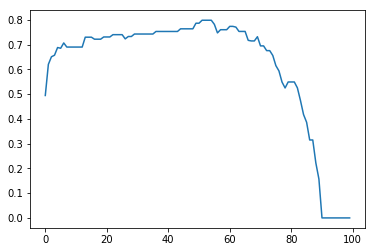

===== n_train = 1 =====
train result: (0.48, 0.7413747288929504)
val result: (0.5, 0.786493608585476)


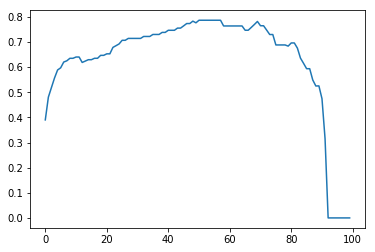

===== n_train = 2 =====
train result: (0.53, 0.7129700870426248)
val result: (0.49, 0.7427214068778905)


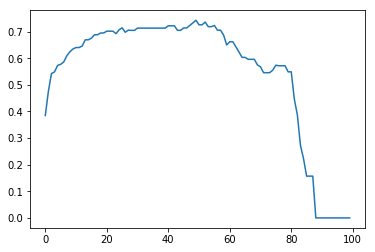

===== n_train = 3 =====
train result: (0.33, 0.7065609044503335)
val result: (0.25, 0.7383990573043504)


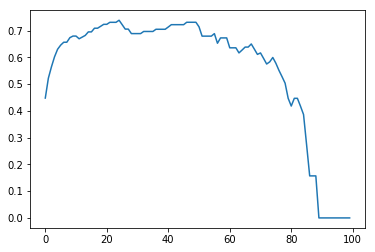

===== n_train = 4 =====
train result: (0.53, 0.6934090999205035)
val result: (0.47000000000000003, 0.7805246753922281)


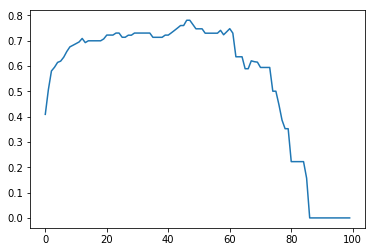

===== n_train = 5 =====
train result: (0.59, 0.7163474940955803)
val result: (0.55, 0.8074057879200641)


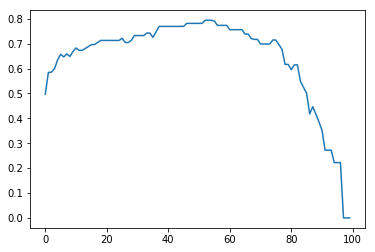

===== n_train = 6 =====
train result: (0.38, 0.7613502854869061)
val result: (0.5, 0.8029923987299143)


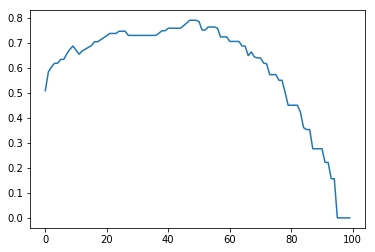

===== n_train = 7 =====
train result: (0.48, 0.6677596867522114)
val result: (0.55, 0.7698907429849168)


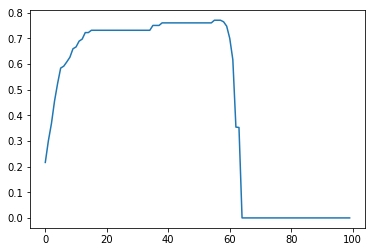

===== n_train = 8 =====
train result: (0.35000000000000003, 0.7651446915314922)
val result: (0.39, 0.7915500774208462)


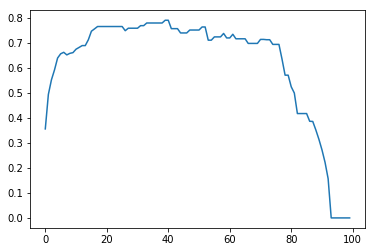

===== n_train = 9 =====
train result: (0.4, 0.7675122930689126)
val result: (0.5, 0.7877587619645293)


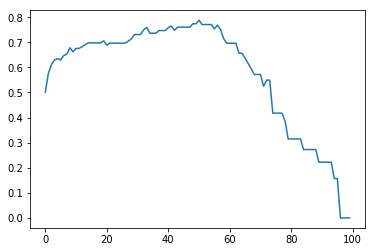

Beginning fold 2
===== n_train = 0 =====
train result: (0.54, 0.7285912223729224)
val result: (0.28, 0.7354686630100679)


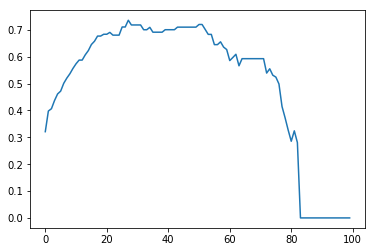

===== n_train = 1 =====
train result: (0.56, 0.7313369550754591)
val result: (0.52, 0.7335466179159049)


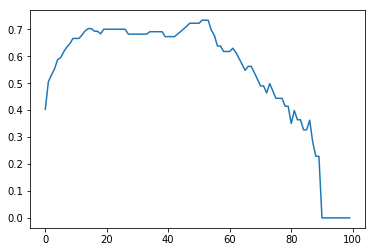

===== n_train = 2 =====
train result: (0.46, 0.7526588617539952)
val result: (0.28, 0.7535338901006076)


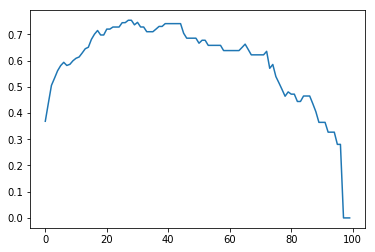

===== n_train = 3 =====
train result: (0.42, 0.7026874263864424)
val result: (0.49, 0.7014256096970901)


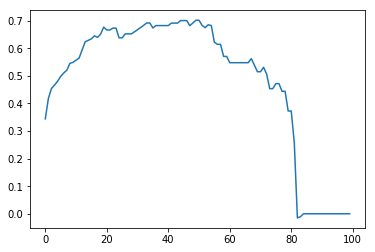

===== n_train = 4 =====
train result: (0.53, 0.6457543390351905)
val result: (0.5, 0.7001320475273803)


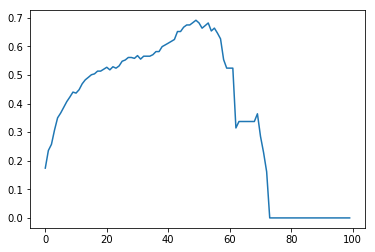

===== n_train = 5 =====
train result: (0.64, 0.7112115508102393)
val result: (0.53, 0.7760687798457508)


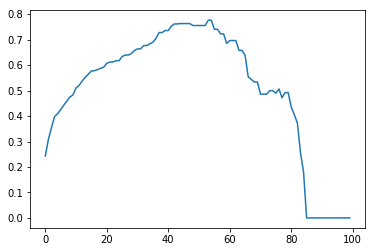

===== n_train = 6 =====
train result: (0.53, 0.7164927258403233)
val result: (0.45, 0.7455328487211981)


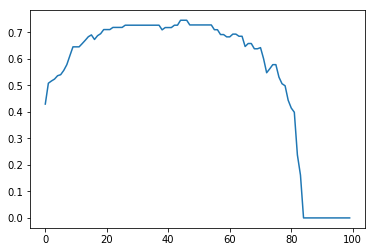

===== n_train = 7 =====
train result: (0.58, 0.7198859884113912)
val result: (0.38, 0.7184784569235291)


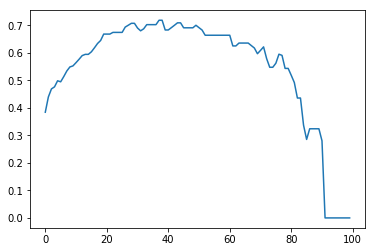

===== n_train = 8 =====
train result: (0.28, 0.7699313035886628)
val result: (0.34, 0.7876012613568159)


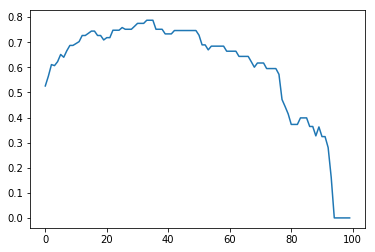

===== n_train = 9 =====
train result: (0.61, 0.7457757317841844)
val result: (0.46, 0.726832968813994)


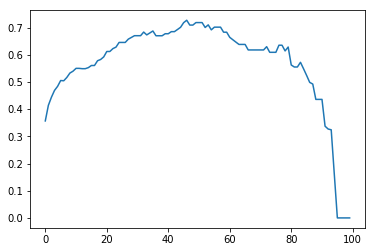

Beginning fold 3
===== n_train = 0 =====
train result: (0.41000000000000003, 0.8206669473316407)
val result: (0.41000000000000003, 0.6363513547423387)


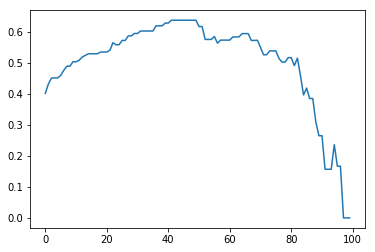

===== n_train = 1 =====
train result: (0.48, 0.744571917796862)
val result: (0.48, 0.6665683930650892)


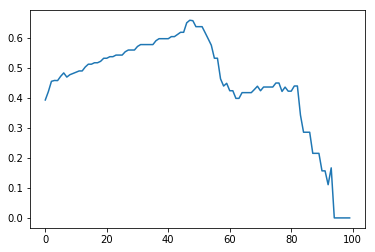

===== n_train = 2 =====
train result: (0.39, 0.7944629803020696)
val result: (0.48, 0.6357581553082031)


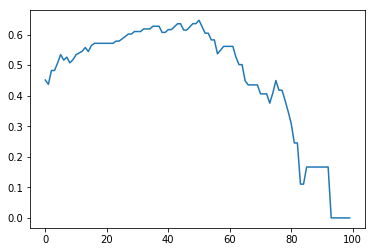

===== n_train = 3 =====
train result: (0.51, 0.7131813710922937)
val result: (0.47000000000000003, 0.6442931922283504)


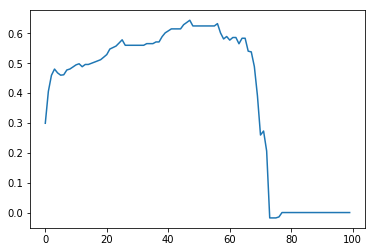

===== n_train = 4 =====
train result: (0.49, 0.806352714026958)
val result: (0.48, 0.6754758691515832)


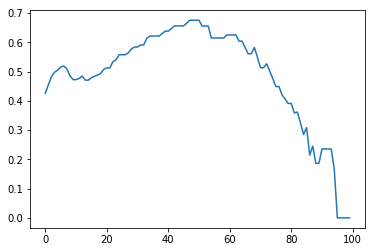

===== n_train = 5 =====
train result: (0.62, 0.7659412026523458)
val result: (0.47000000000000003, 0.6329404607737578)


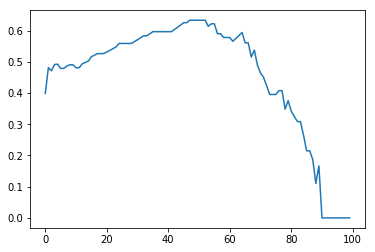

===== n_train = 6 =====
train result: (0.46, 0.7252680288215239)
val result: (0.49, 0.613509155714074)


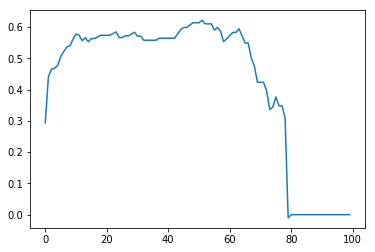

===== n_train = 7 =====
train result: (0.51, 0.757081180179335)
val result: (0.5, 0.6363513547423387)


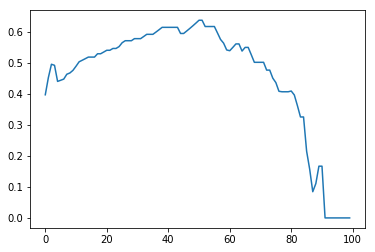

===== n_train = 8 =====
train result: (0.45, 0.782905821520786)
val result: (0.44, 0.6656576740809569)


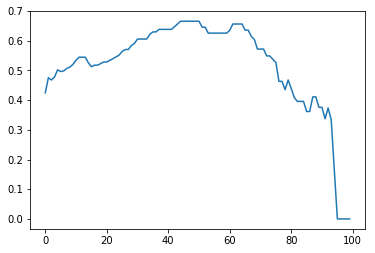

===== n_train = 9 =====
train result: (0.32, 0.8000097401747261)
val result: (0.37, 0.6470652435948566)


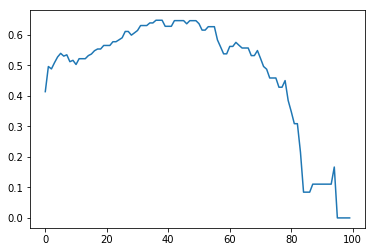

Beginning fold 4
===== n_train = 0 =====
train result: (0.3, 0.7540733008205012)
val result: (0.35000000000000003, 0.6707958157573843)


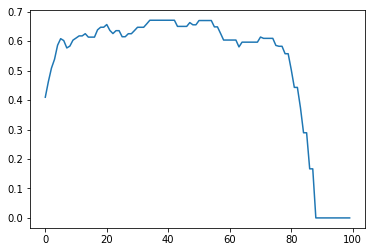

===== n_train = 1 =====
train result: (0.4, 0.7420812108395737)
val result: (0.52, 0.6907920764849713)


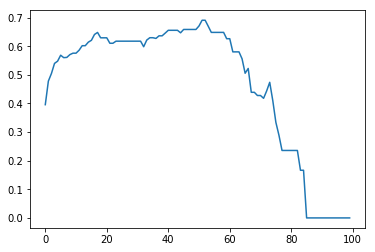

===== n_train = 2 =====
train result: (0.41000000000000003, 0.772326053511044)
val result: (0.38, 0.7039356431116673)


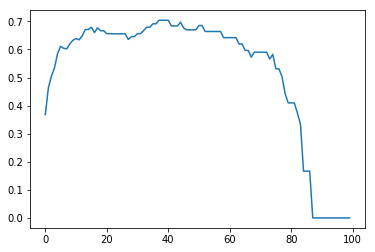

===== n_train = 3 =====
train result: (0.46, 0.790007537620349)
val result: (0.23, 0.7051378924789544)


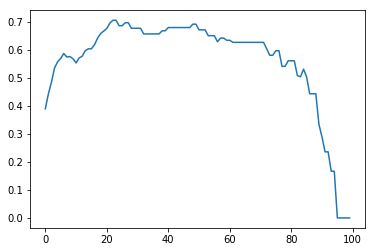

===== n_train = 4 =====
train result: (0.52, 0.7318302710672124)
val result: (0.51, 0.7112025459827352)


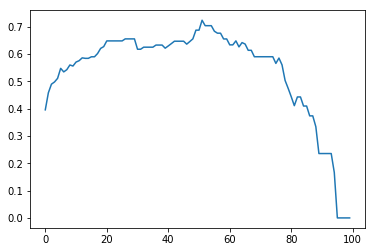

===== n_train = 5 =====
train result: (0.7000000000000001, 0.7243780267712379)
val result: (0.53, 0.6851591405465014)


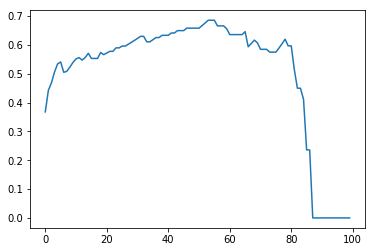

===== n_train = 6 =====
train result: (0.44, 0.757081180179335)
val result: (0.3, 0.6875673346261582)


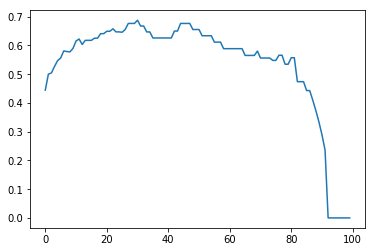

===== n_train = 7 =====
train result: (0.66, 0.7350435534803361)
val result: (0.73, 0.6588445139994814)


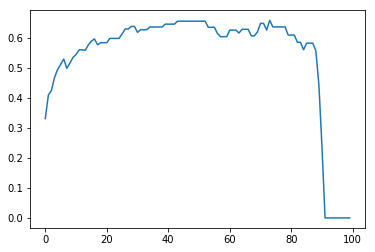

===== n_train = 8 =====
train result: (0.54, 0.7728255099356123)
val result: (0.56, 0.7313358487597429)


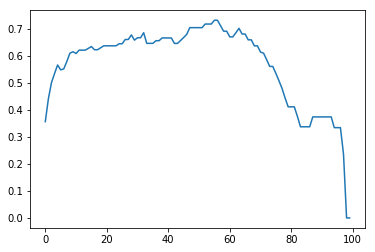

===== n_train = 9 =====
train result: (0.32, 0.7332457240963282)
val result: (0.37, 0.7500538677009265)


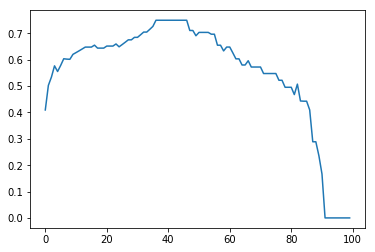

Beginning fold 5
===== n_train = 0 =====
train result: (0.35000000000000003, 0.6996992572898455)
val result: (0.41000000000000003, 0.7928317801395064)


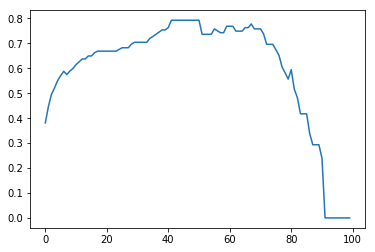

===== n_train = 1 =====
train result: (0.58, 0.7512636046376084)
val result: (0.5, 0.8142609578732489)


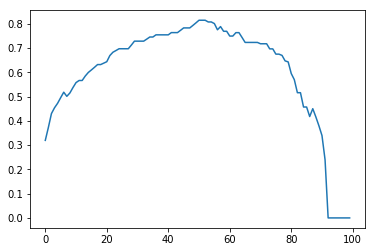

===== n_train = 2 =====
train result: (0.47000000000000003, 0.7280633986502367)
val result: (0.47000000000000003, 0.8071320944249121)


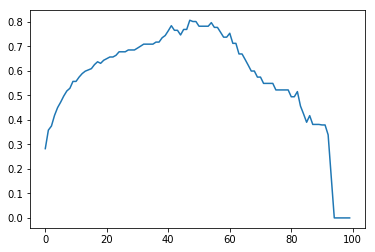

===== n_train = 3 =====
train result: (0.33, 0.7034171595982612)
val result: (0.44, 0.8257887377401847)


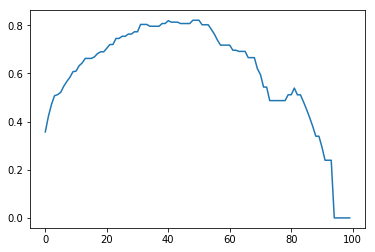

===== n_train = 4 =====
train result: (0.32, 0.6927970094346831)
val result: (0.51, 0.7940911292543559)


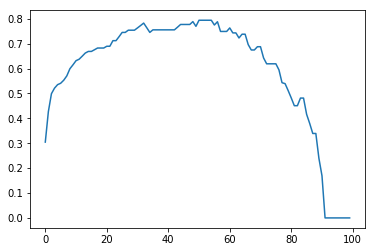

===== n_train = 5 =====
train result: (0.34, 0.689908430592431)
val result: (0.44, 0.7661024196048136)


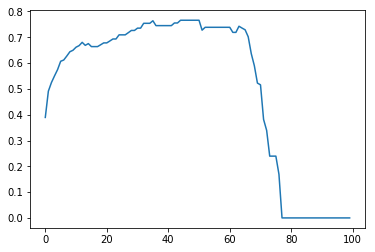

===== n_train = 6 =====
train result: (0.34, 0.6988786414774556)
val result: (0.32, 0.7743030457632759)


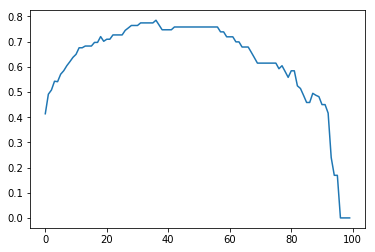

===== n_train = 7 =====
train result: (0.56, 0.749269750383333)
val result: (0.5, 0.8004709628092225)


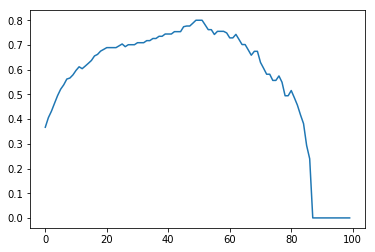

===== n_train = 8 =====
train result: (0.44, 0.7115791383080768)
val result: (0.48, 0.8207612733701637)


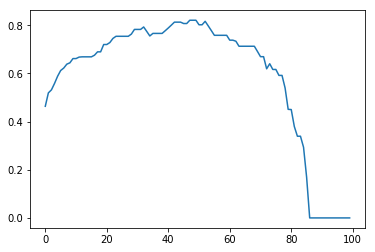

===== n_train = 9 =====
train result: (0.39, 0.6966052778957514)
val result: (0.5, 0.7881482426402234)


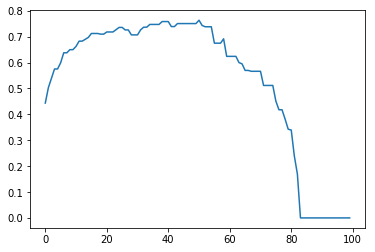

In [61]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for idx, (train_idx, val_idx) in enumerate(splits):
    print("Beginning fold {}".format(idx+1))

    for n_train in range(N_TRAIN):
        print(f"===== n_train = {n_train} =====")
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))
        plot_score(val_y, preds_val)

#### (n_train)単位で結果を出力

===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold0 result: (0.51, 0.7983793818222884)
fold1 result: (0.28, 0.7354686630100679)
fold2 result: (0.41000000000000003, 0.6363513547423387)
fold3 result: (0.35000000000000003, 0.6707958157573843)
fold4 result: (0.41000000000000003, 0.7928317801395064)
val result: (0.5, 0.7182097674144681)


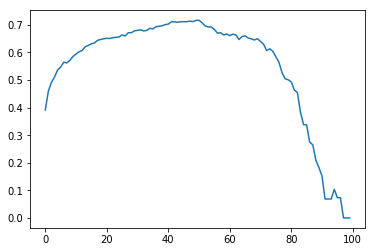

===== n_train = 1 =====
fold0 result: (0.5, 0.786493608585476)
fold1 result: (0.52, 0.7335466179159049)
fold2 result: (0.48, 0.6665683930650892)
fold3 result: (0.52, 0.6907920764849713)
fold4 result: (0.5, 0.8142609578732489)
val result: (0.52, 0.7285697042055385)


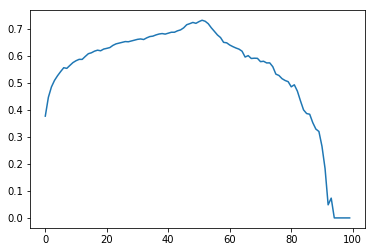

===== n_train = 2 =====
fold0 result: (0.49, 0.7427214068778905)
fold1 result: (0.28, 0.7535338901006076)
fold2 result: (0.48, 0.6357581553082031)
fold3 result: (0.38, 0.7039356431116673)
fold4 result: (0.47000000000000003, 0.8071320944249121)
val result: (0.41000000000000003, 0.7108951607076257)


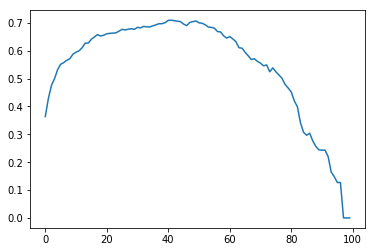

===== n_train = 3 =====
fold0 result: (0.25, 0.7383990573043504)
fold1 result: (0.49, 0.7014256096970901)
fold2 result: (0.47000000000000003, 0.6442931922283504)
fold3 result: (0.23, 0.7051378924789544)
fold4 result: (0.44, 0.8257887377401847)
val result: (0.49, 0.7088421541676777)


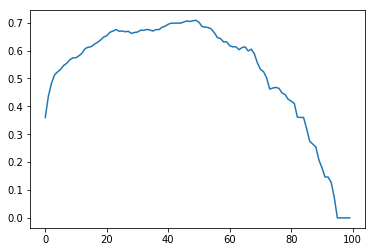

===== n_train = 4 =====
fold0 result: (0.47000000000000003, 0.7805246753922281)
fold1 result: (0.5, 0.7001320475273803)
fold2 result: (0.48, 0.6754758691515832)
fold3 result: (0.51, 0.7112025459827352)
fold4 result: (0.51, 0.7940911292543559)
val result: (0.49, 0.7183677021026861)


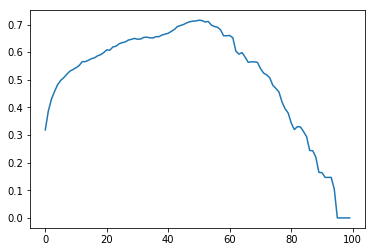

===== n_train = 5 =====
fold0 result: (0.55, 0.8074057879200641)
fold1 result: (0.53, 0.7760687798457508)
fold2 result: (0.47000000000000003, 0.6329404607737578)
fold3 result: (0.53, 0.6851591405465014)
fold4 result: (0.44, 0.7661024196048136)
val result: (0.53, 0.7220854630704842)


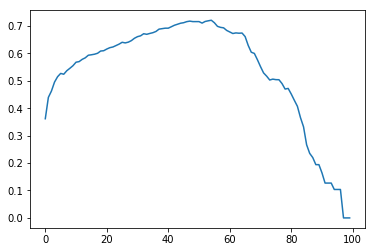

===== n_train = 6 =====
fold0 result: (0.5, 0.8029923987299143)
fold1 result: (0.45, 0.7455328487211981)
fold2 result: (0.49, 0.613509155714074)
fold3 result: (0.3, 0.6875673346261582)
fold4 result: (0.32, 0.7743030457632759)
val result: (0.5, 0.7096336489258003)


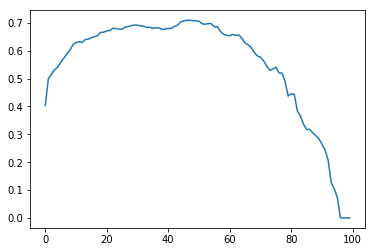

===== n_train = 7 =====
fold0 result: (0.55, 0.7698907429849168)
fold1 result: (0.38, 0.7184784569235291)
fold2 result: (0.5, 0.6363513547423387)
fold3 result: (0.73, 0.6588445139994814)
fold4 result: (0.5, 0.8004709628092225)
val result: (0.5, 0.7105495108179251)


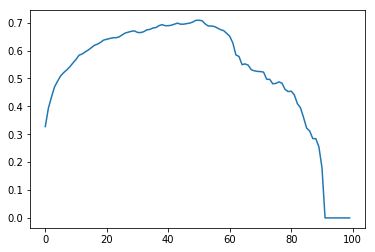

===== n_train = 8 =====
fold0 result: (0.39, 0.7915500774208462)
fold1 result: (0.34, 0.7876012613568159)
fold2 result: (0.44, 0.6656576740809569)
fold3 result: (0.56, 0.7313358487597429)
fold4 result: (0.48, 0.8207612733701637)
val result: (0.48, 0.7354859609700124)


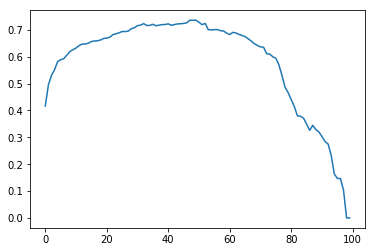

===== n_train = 9 =====
fold0 result: (0.5, 0.7877587619645293)
fold1 result: (0.46, 0.726832968813994)
fold2 result: (0.37, 0.6470652435948566)
fold3 result: (0.37, 0.7500538677009265)
fold4 result: (0.5, 0.7881482426402234)
val result: (0.5, 0.7258273693311693)


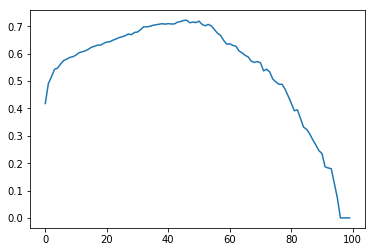

In [62]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)

    print("val result:", threshold_search(y_val, preds_val_all))
    plot_score(y_val, preds_val_all)

### adversarial validation

In [63]:
ad_result = pd.read_csv(save_dir + "adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0").sort_values("idx")
ad_val_idx = ad_train.query("preds > 0.75").idx.values
len(ad_val_idx)

335

In [64]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    val_idx_list = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        val_idx_list.append(val_idx)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)
    val_idx_list = np.concatenate(val_idx_list)
    
    result_df = []
    for idx, target, preds in zip(val_idx_list, y_val, preds_val_all):
        result_df.append((idx, target, preds))
    result_df = pd.DataFrame(result_df, columns=["idx", "target", "preds"])
    result_df = result_df.sort_values("idx").reset_index(drop=True)
    extract = result_df.query("idx in @ad_val_idx")

    print("val result:", threshold_search(y_val, preds_val_all))
    print("adverl result:", threshold_search(extract.target.values, extract.preds.values))

===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold0 result: (0.51, 0.7983793818222884)
fold1 result: (0.28, 0.7354686630100679)
fold2 result: (0.41000000000000003, 0.6363513547423387)
fold3 result: (0.35000000000000003, 0.6707958157573843)
fold4 result: (0.41000000000000003, 0.7928317801395064)
val result: (0.5, 0.7182097674144681)
adverl result: (0.49, 0.5348026142781314)
===== n_train = 1 =====
fold0 result: (0.5, 0.786493608585476)
fold1 result: (0.52, 0.7335466179159049)
fold2 result: (0.48, 0.6665683930650892)
fold3 result: (0.52, 0.6907920764849713)
fold4 result: (0.5, 0.8142609578732489)
val result: (0.52, 0.7285697042055385)
adverl result: (0.52, 0.5690304319011108)
===== n_train = 2 =====
fold0 result: (0.49, 0.7427214068778905)
fold1 result: (0.28, 0.7535338901006076)
fold2 result: (0.48, 0.6357581553082031)
fold3 result: (0.38, 0.7039356431116673)
fold4 result: (0.47000000000000003, 0.8071320944249121)
val result: (0.41000000000000003, 0.7108951607076257)
adverl result: (0.47000000000000003, 0.5873389048330435)
===== n_

### predict v1

- n_train = 2の予測を出力
- LB = 0.640, adverl_resultと似ている？

In [65]:
n_train = 0

In [66]:
preds_test = []
for idx in range(N_SPLITS):
    pred = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
    pred_3 = []

    for pred_scalar in pred:
        for i in range(3):
            pred_3.append(pred_scalar)
    preds_test.append(pred_3)

In [67]:
best_threshold = 0.50
preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)
preds_test.shape

(20337,)

In [68]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = preds_test
submission.to_csv(save_dir + 'submission_v1.csv', index=False)
submission.sum()

signal_id    383962560
target             750
dtype: int64

### predict v2

- 全ての(idx, fold)を足し合わせる

In [69]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]

    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        preds_val_idx += preds_val / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
print("val result:", threshold_search(y_val, preds_val_all))

(0.5700000000000001, 0.8045990907236923)
(0.29, 0.7354686630100679)
(0.5, 0.6656576740809569)
(0.41000000000000003, 0.699126385258153)
(0.56, 0.8207612733701637)
val result: (0.54, 0.728210997113812)


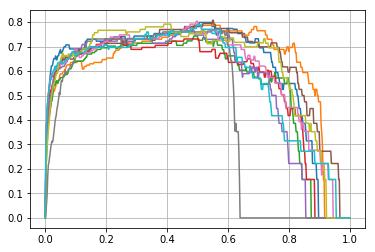

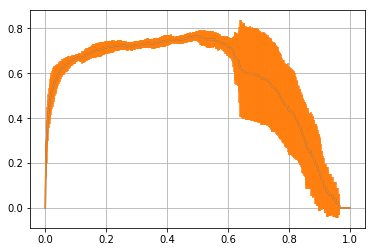

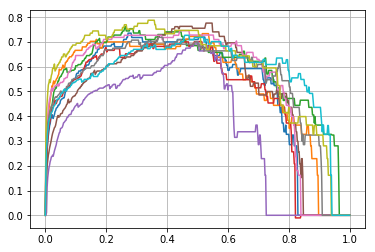

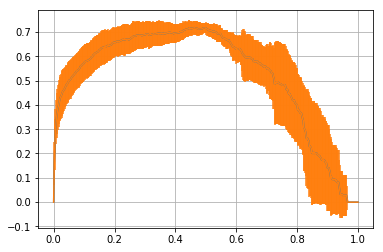

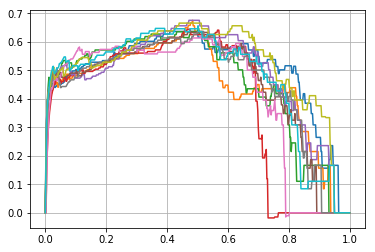

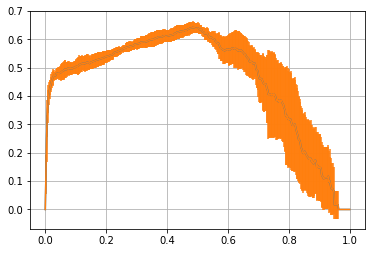

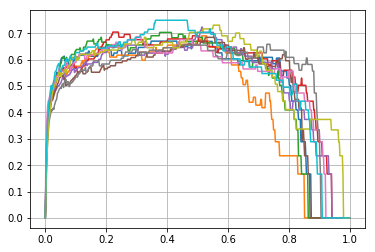

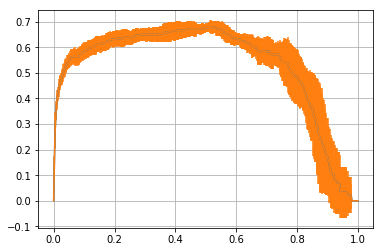

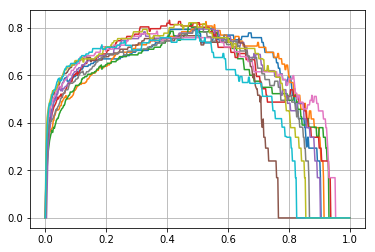

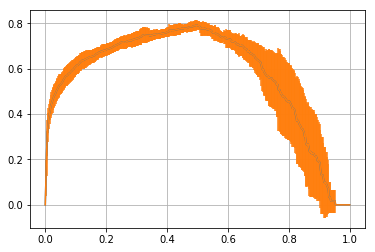

In [70]:
for scores_list in scores_all_fold_list:
    x_line = np.linspace(0.0, 1.0, 501)
    for n_train in range(N_TRAIN):
        plt.plot(x_line, scores_list[n_train])
    plt.grid()
    plt.show()

    mean = np.asarray(scores_list).mean(axis=0)
    std = np.asarray(scores_list).std(axis=0)
    plt.plot(x_line, mean)
    plt.errorbar(x_line, mean, yerr=std)
    plt.grid()
    plt.show()

### predict v3

- 全ての(idx, fold)をsigmoidにスケール変換
- 足し合わせて閾値を決める

In [76]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
preds_test_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        calb = _SigmoidCalibration()
        calb.fit(preds_val, val_y)
        preds_val = calb.predict(preds_val)
        preds_test = calb.predict(preds_test)
        preds_val_idx += preds_val / N_TRAIN
        preds_test_idx += preds_test / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    preds_test_all.append(preds_test_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
print("val result:", threshold_search(y_val, preds_val_all))

(0.39, 0.7915500774208462)
(0.1, 0.7441620022289689)
(0.3, 0.6656576740809569)
(0.48, 0.6907920764849713)
(0.46, 0.8207612733701637)
val result: (0.42, 0.728210997113812)


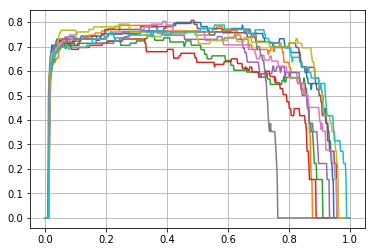

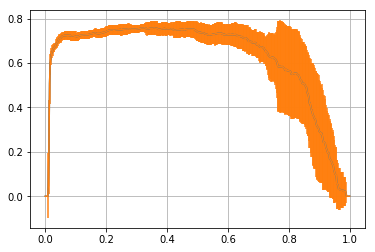

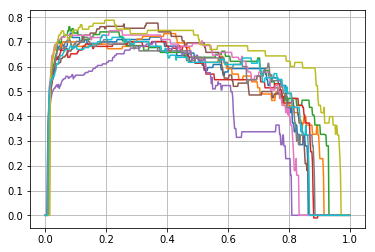

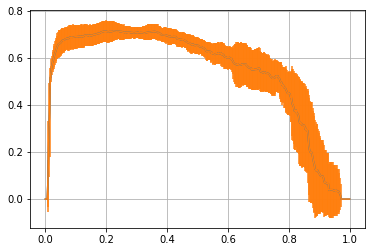

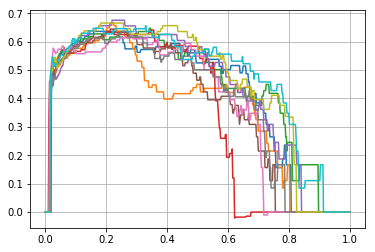

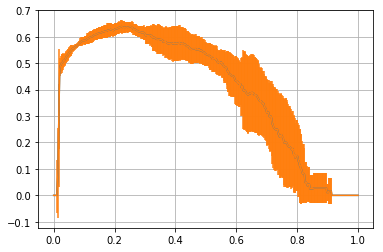

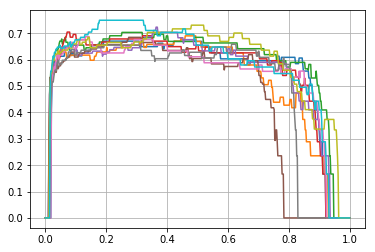

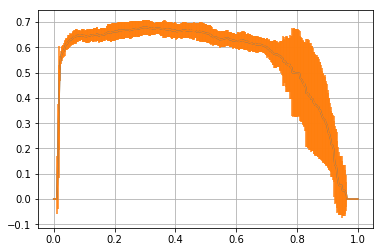

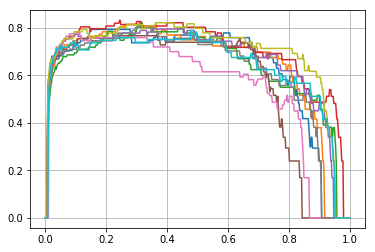

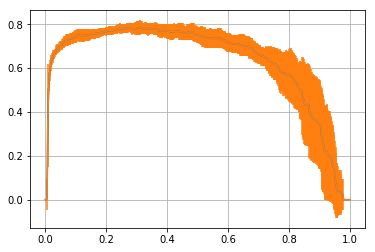

In [77]:
for scores_list in scores_all_fold_list:
    x_line = np.linspace(0.0, 1.0, 501)
    for n_train in range(N_TRAIN):
        plt.plot(x_line, scores_list[n_train])
    plt.grid()
    plt.show()

    mean = np.asarray(scores_list).mean(axis=0)
    std = np.asarray(scores_list).std(axis=0)
    plt.plot(x_line, mean)
    plt.errorbar(x_line, mean, yerr=std)
    plt.grid()
    plt.show()

In [78]:
thr = 0.42
preds_test_sub = np.zeros(len(X_test_input))
for idx, (train_idx, val_idx) in enumerate(splits):
    preds_test_idx = preds_test_all[idx]
    preds_test_sub += preds_test_idx / len(splits)
    
preds_test_sub = (preds_test_sub > thr).astype(int)
preds_test_sub.sum()

237

In [79]:
pred_3 = []
for pred_scaler in preds_test_sub:
    for i in range(3):
        pred_3.append(pred_scaler)
sub = np.squeeze(pred_3)
sub.sum()

711

In [80]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = sub
submission['target'] = submission['target'].astype(int)
submission.to_csv(save_dir + 'submission_v3.csv', index=False)
submission.sum()

signal_id    383962560
target             711
dtype: int64

### predict v4

- 全ての(idx, fold)をrankdataでスケール変換
- 足し合わせて閾値を決める

In [25]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
preds_test_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        preds_con = np.concatenate((preds_val, preds_test))
        preds_con = rankdata(preds_con) / len(preds_con)
        preds_val_rank = preds_con[0:len(preds_val)]
        preds_test_rank = preds_con[len(preds_val):len(preds_val)+len(preds_test)]
        preds_val_idx += preds_val_rank / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    preds_test_all.append(preds_test_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
val_idx_list = np.concatenate(val_idx_list)
result_df = []
for idx, target, preds in zip(val_idx_list, y_val, preds_val_all):
    result_df.append((idx, target, preds))
result_df = pd.DataFrame(result_df, columns=["idx", "target", "preds"])
result_df = result_df.sort_values("idx").reset_index(drop=True)
extract = result_df.query("idx in @ad_val_idx")

print("val result:", threshold_search(y_val, preds_val_all))
print("adverl result:", threshold_search(extract.target.values, extract.preds.values))

(0.9500000000000001, 0.7419595527914675)
(0.96, 0.7339117527952347)
(0.96, 0.7516547735251194)
(0.97, 0.6997985794736116)
(0.93, 0.6709862765338721)
val result: (0.9500000000000001, 0.7099440449269994)
adverl result: (0.9400000000000001, 0.6002884557845183)
